# NLP Project - Classifying Quality Groups of Hebrew Wikipedia Articles

## Matan Kichler, July 2024

# Imports

In [ ]:
# scraping
import requests
import json
import pandas as pd
import numpy as np

# connect to my drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

# embedding
from transformers import AutoTokenizer, AutoModel # Longformer
from transformers import BertModel, BertTokenizerFast # BERT

# classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb # XGBoost

# evaluation
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


# Scraping data and creating dataframe

In [ ]:
featured_articles = [
    "Adenoviridae", "AMX-30", "Evermore (אלבום)", "Fearless", "Folklore (אלבום של טיילור סוויפט)",
    "Francisella tularensis", "In corpore sano", "IWW", "La Isla Bonita", "Love Story", "M1 קרבין",
    "Midnights", "My Heart Will Go On", "P-51 מוסטנג", "Ray of Light", "Say You'll Be There",
    "T-34", "Unicorn (שיר של נועה קירל)", "V-3", "Wannabe", "We Are Never Ever Getting Back Together",
    "אבולוציה של האדם", "אורי אבנרי", "אבשלום", "אדד", "אדם", "אובידיוס", "אוטיזם", "אוניית מערכה",
    "אוניית צובר", "ג'יין אוסטן", "אופרה גרמנית", "אופרה צרפתית", "אוק רידג' (אתר גרעיני)",
    "אוקאפי", "אורן מפותל", "אושוויץ", "אחריות נכסים", "המערכה באוקיינוס האטלנטי במלחמת העולם השנייה",
    "אי הפסחא", "עקיבא איגר", "שמואל נח אייזנשטדט", "אלברט איינשטיין", "איכון באמצעות קול",
    "איליה קפיטולינה", "איליושין Il-28", "אין הולכין בממון אחר הרוב", "אינקה", "פנאיט איסטרטי",
    "אל הסער האנטולי", "אל מריאצ'י", "אל תשאל, אל תספר", "אל תתעסקו עם הזוהן", "אלאגבאלוס",
    "אלבטרוסיים", "יגאל אלון", "מנחם אלון", "שולמית אלוני", "אלוף בצלות ואלוף שום", "אלכסנדר הגדול",
    "וסילה אלכסנדרי", "אלפנט (סרט)", "אלקיביאדס", "נתן אלתרמן", "אמנות חזותית בישראל", "יון אנטונסקו",
    "אנטילופה הודית", "אסון תעופה", "תוכנית אפולו", "אפילפסיה", "אצי, איש הקרח", "אקוסטיקה תת-מימית",
    "אקליפטוס", "ארגון צבאי לאומי", "ארדיפיתקוס רמידוס", "ארכאוזואולוגיה", "ארמון בלנהיים",
    "ארמון הקיץ", "חנה ארנדט", "ארס", "ארסנל", "אשדוד", "לוי אשכול", "אתר המאובנים בצ'נגג'יאנג",
    "באת'", "בבילון 5", "בג\"ץ נוער כהלכה נגד משרד החינוך", "מנחם בגין", "בואינג AH-64 אפאצ'י",
    "בוכנוואלד", "בולגריה במלחמת העולם הראשונה", "בורובודור", "בוריס השלישי, מלך בולגריה",
    "ג'ורג' הרברט ווקר בוש", "ג'ורג' ווקר בוש", "בטיפול", "הפארק הלאומי ביג בנד", "בול ביטוח חיים",
    "בילבי ענק", "בית בודנברוק", "יוסף בכור שור", "רוד בלאגוייביץ'", "שמחה בלאס", "הוגו בלאק",
    "בלבב ימים", "יהדות בלגרד", "אונורה דה בלזק", "הקרב על הבליטה", "בלניים", "ויליאם בלקנאפ",
    "חיים בן עטר", "דוד בן-גוריון", "טוני בנט", "בני דת משה", "בניין מונדנוק", "ישראל בר",
    "דניס ברגקאמפ", "קלרה ברטון", "אלפונס ברטיון", "ג'יימס בריידי", "שרה ברייטמן", "ג'ון דזמונד ברנל",
    "ברצלונה (כדורגל)", "ג'ון ברקינרידג' (תובע כללי)", "בתירת אבי העורקים", "ג'וב יוסף",
    "ג'יימס ג'ויס", "ג'ון אדייר", "ג'ונו (גשושית)", "ג'ונקה", "ג'ורג' החמישי, מלך הממלכה המאוחדת",
    "מייקל ג'ורדן", "ג'ק המרטש", "רוברט ה. ג'קסון", "גאולוגיה של הגרנד קניון", "גבול ארצות הברית–קנדה",
    "גבולות מדינת ישראל", "גבעת המבתר", "גדר הצפון", "גואנו", "ז'וזפ גוארדיולה", "אברהם גולדפאדן",
    "דניאל גולדשמידט", "גורדי שחקים מוקדמים", "הגזענות (ספר)", "גילברט וסאליבן", "גילוי אליהו (ספר)",
    "גלות בבל", "גמר גביע ה-FA 1923", "גנבת הברכות", "חייקה גרוסמן", "ג'יימס גררד", "ג'ורג' גרשווין",
    "משה גרשוני", "גשם בשדה קרב", "דאגרוטיפ", "דאדא", "דבר אליה", "דבש", "דגל אוסטרליה",
    "דגל גרמניה", "דגל הממלכה המאוחדת", "דגל ישראל", "דה הבילנד מוסקיטו", "לאונרדו דה וינצ'י",
    "דו-קרב", "דוב קוטב", "דוברי קוד", "דודו", "ריצ'רד דוקינס", "דורסי לילה", "דחפור די-9 בשירות צה\"ל",
    "דיאטה קטוגנית", "ג'פרסון דייוויס", "משה דיין", "דיינוסוכוס", "קולומבוס דלאנו", "דלות החומר",
    "יצחק דנציגר", "דסטיניז צ'יילד", "דקליים", "דרישה וחקירה", "האגודה היהודית להגנת נערות ונשים",
    "האגם המערבי", "האדם הניאנדרטלי", "האוס (סדרת טלוויזיה)", "ג'יימס האטון", "האם גוגל עושה אותנו טיפשים?",
    "האנדרטה לחללי נשר במערכות ישראל", "הארלם היהודית", "הגט מקליווא", "הגן הארכאולוגי ירושלים",
    "הדד", "הדפס ישראלי", "ההגנה", "ההחלפה האמריקנית הגדולה", "ההסתדרות הכללית של העובדים בארץ ישראל",
    "ההעפלה", "תומאס הובס", "צ'ארלס הוהי", "הומו ארקטוס", "הומו היידלברגנסיס", "הומו פלורסיינסיס",
    "הונים", "הוקי קרח", "הורקנוס לבית טוביה", "הזכוכית הגדולה", "ויליאם הזליט", "החומה הגדולה של סין",
    "החוק להגנת האומה", "החזית המקדונית במלחמת העולם הראשונה", "החזית הסורית במלחמת יום הכיפורים",
    "החיילים היהודים בחיל הספר העבר-ירדני", "החינוך היהודי בבולגריה", "החקיקה בישראל",
    "הטלת פצצות האטום על הירושימה ועל נגסאקי", "הטרק הגדול", "תור היירדאל", "היישוב הישן",
    "היסטוריה של ארסנל", "היסטוריה של נבחרת ישראל בכדורגל", "היסטוריה של תורת ההסתברות", "היפופוטם",
    "אדוארד הית'", "הכיבוש הגרמני באיי התעלה", "הכנרת", "הכרזת העצמאות של רודזיה", "הלוח העברי",
    "מיכאל הלפרן", "המהפכה הצרפתית", "המושל הכללי של ניו זילנד", "המחלוקת על הטקסים הסיניים",
    "המכונית הנשיאותית (ארצות הברית)",
    "המלאכים הטובים של טבענו",
    "המלחמה העות'מאנית-רוסית (1877–1878)",
    "המעיין",
    "המעמד האזרחי-משפטי של יהודי רומניה",
    "המערכה במזרח אפריקה במלחמת העולם השנייה",
    "המערכה על ירושלים במלחמת ששת הימים",
    "המערכה על צרפת ועל ארצות השפלה",
    "המצור על אנטיוכיה (1097–1098)",
    "המרכז הבהאי העולמי",
    "המרכז ההיסטורי של מקאו",
    "המשלחת הטראנס-אנטארקטית של חבר העמים הבריטי",
    "המשמר הפרטוריאני",
    "המשפט בישראל",
    "הנפת הדגל באיוו ג'ימה",
    "הסופרנוס",
    "הסימפוניה החמישית של בטהובן",
    "הסימפוניה הרביעית של מאהלר",
    "הסימפוניה השנייה של מאהלר",
    "העדות הפלוויאנית",
    "העיירה בוערת",
    "העיר האסורה",
    "העלייה לביריה",
    "העלייה מרומניה",
    "הענק הירוק (סרט, 2008)",
    "הערת שוליים (סרט)",
    "הפארק ההיסטורי הלאומי של תרבות צ'אקו",
    "הפארק הלאומי אוורגליידס",
    "הפארק הלאומי גליישר",
    "הפארק הלאומי גרנד טיטון",
    "הפארק הלאומי הוט ספרינגס",
    "הפארק הלאומי וייט סנדס",
    "הפארק הלאומי יוסמיטי",
    "הפארק הלאומי ילוסטון",
    "הפלישה לנורמנדי",
    "הפלנגות הנוצריות",
    "הפנתאון ברומא",
    "הפרעת אישיות גבולית",
    "הפרעת אישיות נרקיסיסטית",
    "הפרעת קשב במבוגרים",
    "הפרעת קשב, ריכוז והיפראקטיביות",
    "הקונסיסטוריה היהודית של בולגריה",
    "הקרנף של דירר",
    "הרופא וגרושתו",
    "הרי וו-יי",
    "הרכבת האווירית לסטלינגרד",
    "הרכבת המנדטורית",
    "הרפתקאות אליס בארץ הפלאות",
    "השומר",
    "השיטה המדעית",
    "השערת שני המקורות",
    "התערוכה העולמית של שיקגו (1893)",
    "התפרצות געשית",
    "התפתחות ציורי ילדים",
    "התקופה הממלוכית בארץ ישראל",
    "ואסה (אונייה)",
    "קוזימה וגנר",
    "ויאהב אומן",
    "נפתלי הרץ וייזל",
    "וילהלם השני, קיסר גרמניה",
    "וריאציות דיאבלי",
    "זאב ז'בוטינסקי",
    "ז'יזל",
    "זאב הרעמה",
    "זאב טסמני",
    "זירת חצי האי האפניני במלחמה הפונית השנייה",
    "סם זמוריי",
    "יוסף זריצקי",
    "פרנסיסקו חאווייר",
    "חגורת המנינגיטיס האפריקנית",
    "חומות ירושלים",
    "חומת ברלין",
    "חוק ההסדרים",
    "חוק הרשויות המקומיות (הסמכה מיוחדת)",
    "חוק יסוד: נשיא המדינה",
    "חוקי קפלר",
    "חור שחור",
    "אבא חושי",
    "חזקה (מתמטיקה)",
    "חטיבה 188 במלחמת יום הכיפורים",
    "חטיבת ירושלים",
    "חי\"ש",
    "חידות חיתוך והרכבה",
    "חידת שמשון",
    "חיל האוויר הרוסי",
    "חיל ההנדסה הקרבית",
    "חיל הספר העבר-ירדני",
    "חלוקה מנהלית של האימפריה העות'מאנית",
    "חמאה",
    "חמת גדר",
    "חניבעל",
    "חשיפה עצמית בטיפול",
    "טבח יער רומבולה",
    "טביליסי",
    "טביעת האונייה מצדה",
    "טביעת הצוללת דקר",
    "טבריה",
    "שרה טהון",
    "טורנדו על קנזס",
    "טורפדו",
    "פול טיבטס",
    "טיגר",
    "טיסה 19",
    "טיפול באמנות",
    "ישיבת טלז",
    "טלסקופ החלל האבל",
    "טרוטת עין-הקשת",
    "טריצרטופס",
    "טרנאטה",
    "יאו מינג",
    "יאמטו (אוניית מערכה, 1940)",
    "יגואר",
    "יהדות בולגריה",
    "יהדות בוקרשט",
    "יהדות ביטולה",
    "יהדות זאגרב",
    "יהדות מרוקו",
    "יהדות סופיה",
    "יהדות סרייבו",
    "יהדות פלובדיב",
    "יהל\"ם",
    "יוון הארכאית",
    "יוון הקלאסית",
    "טד יוז",
    "קרב יוטלנד",
    "יוליאנוס הכופר",
    "יוליסס",
    "יום אוסטרליה",
    "יום אנזא\"ק",
    "יומנה של אנה פרנק",
    "יחידה 707",
    "יחסי אישות (הלכה)",
    "יחסי הפיליפינים–ישראל",
    "יחסי ישראל – סרי לנקה",
    "יחסי ישראל–מלזיה",
    "צ'אק ייגר",
    "ים המלח",
    "ימחד",
    "ימי החנוכה",
    "יצרים",
    "ירגזי מצוי",
    "ירושלים בתקופה הביזנטית",
    "ירושלים בתקופה הצלבנית",
    "ישראל במלחמת יום הכיפורים",
    "ישראל במלחמת סיני",
    "כיבוש האימפריה הפרסית על ידי אלכסנדר הגדול",
    "הכיבוש הערבי של ארץ ישראל",
    "כיבוש קונסטנטינופול",
    "כיבושי אלכסנדר הגדול באסיה התיכונה",
    "כלנית מצויה",
    "כניעת האימפריה היפנית",
    "כנסיית הקבר",
    "כפר סבא",
    "לאופולד בלום",
    "לווייתן כחול",
    "לווייתנאים",
    "יצחק בר לווינזון",
    "לוטרת הים",
    "ג'ון לוק",
    "לוקהיד SR-71",
    "לחשוב מהר, לחשוב לאט",
    "אליעזר ליבנה",
    "ליבת קרח",
    "יעקב לידסקי",
    "לילית אפורה",
    "לנדסמנשאפט",
    "ג'ון לנון",
    "פרדיננד לסל",
    "לקות למידה",
    "מאגמה",
    "מאוטהאוזן",
    "מאיץ LHC",
    "גאיוס קילניוס מאיקנס",
    "תומאס מאן",
    "אטיין-ז'ול מארה",
    "בוב מארלי",
    "מבצע ערצב 19",
    "מבצע פעמון החירות",
    "מבצע שומר ראש",
    "מבצרים צלבניים במזרח התיכון",
    "מגדלי האנוי",
    "מדיניות החוץ של ממשל ג'ורג' ווקר בוש",
    "מדיניות הפנים של ממשל ג'ורג' ווקר בוש",
    "מדיניות לשונית בישראל",
    "מהדי",
    "מהר\"ל מפראג",
    "מוות בוונציה",
    "מוזיקה יהודית",
    "מוזיקה קלאסית בתקופה המודרנית",
    "מוזיקה קלאסית ישראלית",
    "רוברט מולדון",
    "מועדון סיירה",
    "וולפגנג אמדאוס מוצרט",
    "מושבת הכף ההולנדית",
    "מחלקת הל\"ה",
    "מיג-25",
    "קרב מידוויי",
    "מריה מיטשל",
    "סבסטיאן מינסטר",
    "מיסטר בין",
    "מיראז' 3",
    "מיתוסים של מבול",
    "מכבי חשמונאי ירושלים",
    "מכניקה קלאסית",
    "מלאקה",
    "מלחמת גאליה",
    "מלחמת האזרחים בספרד",
    "מלינצ'ה",
    "מנורת הכנסת",
    "מניהוט מצוי",
    "מניין השנים בלוח העברי",
    "מסה על שכל האדם",
    "מסוק",
    "מסע הסירה ג'יימס קיירד",
    "מסעותי עם דודתי",
    "מעטפת בואנוויל",
    "מעכבי אנזימים",
    "מערכות המסתור של בר כוכבא",
    "מערכות מספרים",
    "מערכת הצוללות במלחמת העולם הראשונה",
    "מערת הנחל",
    "מערת מיסליה",
    "מעשה העז",
    "מפעלי עמק דרוונט",
    "מצדה",
    "מקדונל דאגלס F-15 איגל",
    "מקדש אדפו",
    "מקדש השמיים",
    "ג'ון מקיין",
    "מרד החשמונאים",
    "מרד הלגיונרים ופרעות בוקרשט",
    "מרחב-זמן",
    "מרי רוז",
    "מרכבה (טנק)",
    "מרכז הכרמל",
    "משבר קרנות הפנסיה הגרעוניות",
    "משחקי שעשוע",
    "משטרת המנדט",
    "משינה",
    "משלחת דיסקברי",
    "משלחת הקוטב הדרומי",
    "משלחת טרה נובה",
    "משלחת נמרוד",
    "משלחת צלב הדרום",
    "משמר הגבול",
    "משפט פיתגורס",
    "משפט קנטור",
    "משפט שלמה",
    "מתואלים",
    "יצחק נבון",
    "נבחרת ארץ ישראל בכדורגל",
    "נביעה הידרותרמית",
    'נגמ"שים כבדים בצה"ל',
    "נוקליאוסינתזה",
    "נחליאלי לבן",
    "ניסויים בלשניים בקופי אדם",
    "ניצוח",
    "נמל התעופה בן-גוריון",
    "נמר השלג",
    "נמרוד (פסל)",
    'נסיגת צה"ל מסיני ומעזה (1956–1957)',
    "נקבת השילוח",
    "נקמת האבות",
    "נשות ניחומים",
    "נשר (עיר)",
    "סבויה מרקטי SM.79",
    "סדר ליל ראש השנה",
    "טיילור סוויפט",
    "סוכרת מסוג 2",
    "סופרים קומנדר",
    "סופרמן",
    "סטטוס קוו (המקומות הקדושים)",
    "אדווין סטנטון",
    "אלג'רנון סידני",
    "סימולאקרה",
    "סכיזופרניה",
    "סכר הובר",
    "סכר קניון גלן",
    "סמנתה סמית'",
    "ג'דדיה סמית",
    "טובה סנהדראי",
    "סנט קילדה",
    "רב סעדיה גאון",
    "ספינות הסער",
    "ספינות שרבורג",
    "ספרייה",
    "ספריית גרשם שלום",
    "סקאר",
    "צ'ארלס סקוט (מושל)",
    "אריאדנה סקריאבינה",
    "דומניקו סקרלטי",
    "סרטן השד",
    "שמואל יוסף עגנון",
    "עוצמה סייסמית",
    "עיטם לבן-ראש",
    "עיתונות עברית",
    "עיתונות ערבית",
    "על הדרך עץ עומד",
    "עלילות בעל וענת",
    "עלילת החמור",
    "עם עולם",
    "עמוק באדמה",
    "עצים עתיקים בארץ ישראל",
    "עקרה (שיר)",
    "פאנצר סימן 4",
    "פאסיל גמב",
    "פדיון יהודי רומניה",
    "רזא שאה פהלווי",
    "פוגה",
    "שניאור זלמן פוגצ'וב",
    "פודו דרומי",
    "פוטון",
    "הארי פוטר (דמות)",
    "קרלס פויול",
    "פייבל פולקס",
    "מישל פוקו",
    "פזמון ליקינתון",
    "פלינדרס פיטרי",
    "שלמה פיינגולד",
    "פיליבסטר",
    "פיליפוס החמישי, מלך מוקדון",
    "פרנאו מנדש פינטו",
    "פיסול ישראלי",
    "מתי פלד",
    "פלה",
    "פסטיבל ביירוית",
    "פסיכופתיה",
    "פסק דין אדוארדס נגד אגילארד",
    "פסק דין ירוס-חקק נגד היועץ המשפטי לממשלה",
    "פסק דין ניו יורק טיימס נגד סאליבן",
    "פעולת כראמה",
    "פצצה על טנק",
    "פר גינט",
    "פרארי (קבוצת מרוצים)",
    "פרדיקס",
    "פרוטו-הודו-אירופית",
    "פרויקט מנהטן",
    "פרידריך השני, קיסר האימפריה הרומית הקדושה",
    "פריז",
    "פריקס",
    "אנה פרנק",
    "שמעון פרס",
    "פרעושים",
    "פרעות יאשי",
    "פרק 1 לחוקת ארצות הברית",
    "פרק 2 לחוקת ארצות הברית",
    "פרק 3 לחוקת ארצות הברית",
    "פרקי דרבי אליעזר",
    "פרקים של ספר המדינה",
    "פרשת דרייפוס",
    "פרשת הסרג'נטים",
    "פרשת הרצח בחולות תל נוף",
    "פרשת ווטרגייט",
    "פרשת ניסוי האנתרקס",
    "פרשת תמאם שוד",
    "צ'אבי",
    "ניקולאה צ'אושסקו",
    "צ'ינדיטים",
    "וילט צ'מברלין",
    "צ'ארלי צ'פלין",
    "צופון",
    "ציורי הסלע בוואל קמוניקה",
    "צילום מורכב",
    "צילום פוסט-מורטם",
    "פאול צלאן",
    "צלמיות במזרח הקרוב ובעולם האגאי הקדום",
    "צמצום (הלכה)",
    "צפע מצוי",
    "צרפת החופשית",
    "קאקאפו",
    "קבוצת המזרח הרחוק",
    "קבוצת ים רוס",
    "קבוצת קנטור",
    "קברי שושלת מינג",
    "קדר (שבט וממלכה)",
    "קובוץ ושורוק",
    "קודו גמלוני",
    "קורנליו זליה קודריאנו",
    "קולורדו (נהר)",
    "קולנוע חרדי",
    "קולרבו",
    "יהדות קונסרבטיבית",
    "פרנסיס פורד קופולה",
    "די. בי. קופר",
    "אברהם יצחק הכהן קוק",
    "עמוס קינן",
    "קינת ניפור",
    "קירה קירלינה",
    "קלאופטרה",
    "קלאמת (נהר)",
    "ישראל יעקב קליגלר",
    "הילרי קלינטון",
    "קמרה אובסקורה",
    "ג'ורג' קנאן",
    "דגל קנדה",
    "ישראל קסטנר",
    "קפאת-עד",
    "חוסה ראול קפבלנקה",
    "קרב אוויר",
    "קרב גוודלקנל",
    "קרב גרניקוס",
    "קרב הייסטינגס",
    "קרב הירמוך",
    "קרב חרן",
    "קרב מפרץ הלגולנד הראשון",
    "קרב סטלינגרד",
    "קרב קאנאי",
    "קרב קדש",
    "קרב קורסון-צ'רקאסי",
    "קרב קרני חיטין",
    "קרב שילה",
    "קרב שרטון דוגר (1915)",
    "קרול הראשון, מלך רומניה",
    "ג'ון קריטנדן",
    "הפארק הלאומי קרייטר לייק",
    "קרייסיס",
    "קריית עיריית ירושלים",
    "טום קרין",
    "קריפטוגרפיה",
    "אברהם ישעיהו קרליץ",
    "קרמיקה ישראלית",
    "קרנף סומטרה",
    "הקרע ביהדות הונגריה",
    "קרפדת קנים",
    "קרקלה",
    "קתדרלת קלן",
    "קתדרלת שארטר",
    "ראשתן גדול-ראש",
    "רביעיות חליל של מוצרט",
    "מערכת הפארקים רדווד",
    "פנחס רוטנברג",
    "ג'ון רולס",
    "רוקד עם זאבים",
    "גדעון רז",
    "רחוב הנביאים",
    "רחוב ירושלים (חיפה)",
    "לואי ריאל",
    "מטאו ריצ'י",
    "רכבות במצרים",
    "רכבת העמק",
    "רעידת האדמה באגאדיר (1960)",
    "רצח סלינה",
    "רצח פרנץ פרדיננד",
    "שדרות רוטשילד",
    "שומייקר-לוי 9",
    "שונר איברי",
    "שושלת מינג",
    "שחמט",
    "הרמן שטרוק",
    "שיגעון הג'ין",
    "שיחות ליד האח",
    "שייטת הטרפדות",
    "שייטת ספינות הטילים",
    "שימפנזה מצוי",
    "שיר של אש ושל קרח",
    "שירי מכות מצרים",
    "גרשם שלום",
    "שליחי הג'אז",
    "שלמה סולימן אלסנג'ארי",
    "שמואל דוד לוצאטו",
    "שמורות הפנדה הענק בסצ'ואן",
    "יצחק שמיר",
    "שנאת ישראל בעולם היווני-רומי",
    "שני תלמידי חכמים שהיו בעירנו",
    "שעון קיץ",
    "ארתור שפנייר",
    "אנג'ליקה שץ",
    "ג'ון שרמן",
    "שתי מסכתות על ממשל מדיני",
    "תאונת המכרה בצ'ילה (2010)",
    "תאוריית ברונסטד–לאורי",
    'תהילים קנ"א',
    "תוכנית הפדרציה",
    "יגאל תומרקין",
    "תזונת ימי הביניים",
    "תחיית הלשון העברית",
    "תחרות הזמר של האירוויזיון",
    "תיאור מפעלותיו של אוגוסטוס האלוהי",
    "תיאטרון יידיש",
    "תכנון ליניארי",
    "תכנון עירוני של ברצלונה",
    "תל אבו הואם",
    "תל אביב במלחמת העצמאות",
    "תלפיות",
    "תנו לסוני צ'אנס",
    "תנועת החסידות",
    "תנין היאור",
    "תנין הים",
    "תנינאים",
    "תעודות אל-יהודו",
    "תעלת דנובה–הים השחור",
    "תעלת הימים",
    "תקנות הקהילה",
    "תקרית רוזוול",
    "תקשורת הספורט בישראל"
]

regular_articles = [
 'תאג"ד (סדרת טלוויזיה)',
 'מגפת הקורונה (2019–2020)',
 'פאודה',
 'התפרצות נגיף הקורונה בישראל',
 'קורונה (נגיף)',
 'איחוד האמירויות הערביות',
 'השפעת הספרדית',
 'עידן רפאל חביב',
 'סדרות (אתר אינטרנט)',
 'טהרן (סדרת טלוויזיה)',
 'שעת נעילה (סדרת טלוויזיה)',
 'קובי בראיינט',
 'סארס',
 'יצחק רבין',
 'המעילה בבנק למסחר',
 'קערת ליל הסדר',
 'יהודה בארקן',
 'הישרדות (תוכנית טלוויזיה ישראלית)',
 'התפרצות נגיף קורונה-ווהאן',
 'פסטיגל',
 'האח הגדול (תוכנית טלוויזיה ישראלית)',
 'מדינות לפי אוכלוסייה, שטח, צפיפות, תמ"ג ופיתוח אנושי',
 'אליזבת השנייה, מלכת הממלכה המאוחדת',
 'קופה ראשית',
 'האנטומיה של גריי (סדרת טלוויזיה)',
 'ענת אלימלך',
 "ג'ו ביידן",
 'גוגל תרגום',
 'הזמר במסכה (תוכנית טלוויזיה ישראלית)',
 'המוות השחור',
 'דונלד טראמפ',
 'מלחמת העולם השנייה',
 'המורדת (מיני-סדרה)',
 'מלחמת העולם הראשונה',
 'נמלטים',
 'המירוץ למיליון (תוכנית טלוויזיה ישראלית)',
 'יפעת שאשא-ביטון',
 'דמוגרפיה של ישראל',
 'קיבוצניקים (סדרת טלוויזיה)',
 'יומני הערפד',
 'ראש ממשלת ישראל',
 'ירושלים',
 'בני גנץ',
 'מגפת הקורונה',
 'משה בר סימן טוב',
 'מנאייכ',
 'הישרדות VIP עונה 3',
 'שירה האס',
 'פלמ"ח (סדרת טלוויזיה)',
 'צחי הלוי',
 'בית הנייר',
 'ערים בישראל',
 'רוני גמזו',
 'מילת קישור',
 'יד2',
 'אייל גולן',
 'ניב סולטן',
 'היקום הקולנועי של מארוול',
 'הרפובליקה העממית של סין',
 'גלית גיאת',
 'גבי ברבש',
 'נגיף',
 'שנות ה-80 (סדרת טלוויזיה)',
 'רוסיה',
 'תל אביב-יפו',
 'חטיבת גולני',
 'אלי כהן',
 'איטליה',
 'בנימין זאב הרצל',
 'יועז הנדל',
 'מחלת נגיף קורונה 2019',
 'דייגו מראדונה',
 'אדולף היטלר',
 'כריסטיאנו רונאלדו',
 'מאיה ורטהיימר',
 'כחול לבן (רשימה)',
 'סברי מרנן (סדרת טלוויזיה)',
 'יגאל עמיר',
 'גל גדות',
 'גלגל המזלות',
 'קרן מרציאנו',
 'הבחירות לכנסת העשרים ושלוש',
 'נס בתא מספר 7',
 'אביב כוכבי',
 'יונית לוי',
 'מאור בוזגלו',
 'השמיניה (סדרת טלוויזיה)',
 'אסי בוזגלו',
 'דני אבדיה',
 'לוציפר (סדרת טלוויזיה)',
 'נועה קולר',
 'משרד הבריאות',
 'כדור הארץ',
 'זאב צעיר (סדרת טלוויזיה)',
 '5G',
 'דניאל ליטמן',
 'מדינות לפי שם',
 'צרפת',
 'כנופיית ברמינגהאם',
 'בחריין',
 'יולי אדלשטיין',
 'מדינות ארצות הברית',
 'בת השוטר',
 'שבועות',
 'הטבלה המחזורית',
 'בלקספייס',
 'יעקב ליצמן',
 'חברים',
 'יונתן פולארד',
 'עומר אדם',
 'לוסי אהריש',
 'אווטאר (סדרת טלוויזיה)',
 'עשרת הדיברות',
 'סוג דם',
 'הבונים החופשיים',
 'אליאנה תדהר',
 'איראן',
 'כפולה',
 'יורם לס',
 'שטיסל',
 'הממלכה המאוחדת',
 "ירדן ג'רבי",
 'רינת גבאי',
 'רמב"ם',
 "לברון ג'יימס",
 'אריאל שרון',
 'SARS-CoV-2',
 'אריה',
 'דובאי',
 'עדי ביטי',
 'השואה',
 'הבחירות לנשיאות ארצות הברית 2020',
 'מלחמת לבנון הראשונה',
 'נשיא מדינת ישראל',
 'השיר שלנו',
 'ליאור רז',
 '2020',
 'נפתלי בנט',
 'זהויות טריגונומטריות',
 'חטיבת הצנחנים',
 'רותם סלע',
 'ישו',
 'אביב אלוש',
 'תומר קאפון',
 'שירה נאור',
 'מכבי תל אביב (כדורגל)',
 'האי (סדרת טלוויזיה)',
 'איציק כהן (שחקן)',
 'עמית סגל',
 'חנוכה',
 'הודו',
 'אוסנת מארק',
 "עומר ינקלביץ'",
 'אהוד ברק',
 'בילי אייליש',
 'סמיון גרפמן',
 'הילה קורח',
 'דוד',
 'מיכל אמדורסקי',
 'עידן רייכל',
 'מערכת השמש',
 'גרמניה',
 'גדעון סער',
 'ויקיפדיה',
 'גמביט המלכה (סדרת טלוויזיה)',
 'חתונה ממבט ראשון',
 'דרגות משטרת ישראל',
 'אילומינטי',
 'קים קרדשיאן',
 'סוכות',
 'משפחת קרדשיאן',
 'הארי פוטר',
 'עמליה דואק',
 'מגפה',
 'אהוד אולמרט',
 'שולה זקן',
 "וינסטון צ'רצ'יל",
 'אוסטרליה',
 'תנ"ך',
 "לירז צ'רכי",
 'ליגת האלופות',
 'זיגמונד פרויד',
 'התקווה',
 'אנגלית',
 'הכרזת העצמאות',
 'ליאנה עיון',
 'רינה מצליח',
 'הליכוד',
 'ארץ נהדרת',
 'מירי רגב',
 'פשיזם',
 'החממה',
 'רכבת ישראל',
 'מיקי זוהר',
 'טיילור מלכוב',
 'ממשלת ישראל השלושים וחמש',
 'חיים נחמן ביאליק',
 'מצרים',
 'ליגת ה-NBA',
 'יהונתן מרגי',
 'טורקיה',
 'מעיין אדם',
 'אנה זק',
 'ספיידרז',
 'אריק איינשטיין',
 "ג'וי ריגר",
 'אריאנה גרנדה',
 'קופיקו (סדרת טלוויזיה)',
 'ספרד',
 'בפנים',
 'צבא הגנה לישראל',
 'נסרין קדרי',
 'שפעת',
 'הפנתרים השחורים',
 'יגאל בשן',
 'יחידות מובחרות בצה"ל',
 'קידומת טלפון בישראל',
 'ביל גייטס',
 'ריף נאמן',
 'נשיאי ארצות הברית',
 'גואל רצון',
 'בניינים בעברית',
 'מכבי תל אביב (כדורסל)',
 'יוסיף סטלין',
 'גאליס',
 'ערב הסעודית',
 'אילון מאסק',
 'קומוניזם',
 'כמעט מלאכים',
 'רן דנקר',
 'קנדה',
 'דמוגרפיה של העולם',
 'מכבי חיפה (כדורגל)',
 'אליעזר בן-יהודה',
 'יוסי כהן',
 'ניו יורק',
 'אבעבועות שחורות',
 'שבעת המינים',
 'שייטת 13',
 'דרוזים',
 'חנן בן-ארי',
 'פיגועי 11 בספטמבר',
 'הנסיכה מרגרט, רוזנת סנודן',
 'פאי',
 'זהר שטראוס',
 'מרוקו',
 'ליהי קורנובסקי',
 "ג'ניפר אניסטון",
 "ונטוורת' מילר",
 'הצהרת בלפור',
 'הורדוס',
 'אמיר חצרוני',
 'אגם רודברג',
 'מארינה מקסימיליאן',
 'ולדימיר פוטין',
 'שבטי ישראל',
 'ערן זהבי',
 'ויקינגים (סדרת טלוויזיה)',
 "מייקל ג'קסון",
 'אינסטגרם',
 'דנה ויס',
 'דבר (מחלה)',
 "צ'ארלי ד'אמליו",
 'דיאנה, הנסיכה מוויילס',
 'הפרעה דו-קוטבית',
 'אופירה אסייג',
 'ניקול ראידמן',
 'סדרה הנדסית',
 'דין מירושניקוב',
 'יום הכיפורים',
 'עידן עמדי',
 'חלבון',
 "הפיג'מות",
 'סוריה',
 'יאיר לפיד',
 'יפן',
 "אסון צ'רנוביל",
 'עפר שלח',
 'כוכב לכת',
 'זגורי אימפריה',
 'עשרה בטבת',
 'אסלאם',
 "אייל ברקוביץ'",
 'בית"ר ירושלים',
 'הנסיך פיליפ, דוכס אדינבורו',
 'מלחמת המפרץ',
 'גוגל (חברה)',
 'בנק הפועלים',
 'קמלה האריס',
 'חילי טרופר',
 'בר רפאלי',
 'טד בנדי',
 'פבלו אסקובר',
 'גלעד שליט',
 'חיפה',
 'עוז זהבי',
 "האימפריה העות'מאנית",
 'טיפול המרה',
 'רמדאן',
 'צומת מילר (סדרת טלוויזיה)',
 'תום אבני',
 'חיים אתגר',
 "צ'ארלס, נסיך ויילס",
 'משה',
 'דן אריאלי',
 'עפרה חזה',
 'פרשת נעמה יששכר',
 'ריברדייל (סדרת טלוויזיה)',
 'המוסד למודיעין ולתפקידים מיוחדים',
 'שלמה ארצי',
 'הבוזגלוס',
 "קיילי ג'נר",
 'ברזיל',
 'יחסי מין',
 'המקוריים',
 'בית ספר למוסיקה (תוכנית טלוויזיה)',
 'ל"ג בעומר',
 'כ"ט בנובמבר',
 'תשעה באב',
 'מרים פרץ',
 'רצח יצחק רבין',
 "בורג' ח'ליפה",
 'אברהם',
 'איתי לוי',
 'יהודים',
 'זאת וזאתי',
 'עומר אצילי',
 'אמיר אוחנה',
 'לוסי איוב',
 'איסלנד',
 'ראש השנה',
 'מיינקראפט',
 'אילן רמון',
 'זכויות האדם',
 'הבחירות לכנסת העשרים ושתיים',
 "קים ג'ונג-און",
 'הסולטאן (סדרת טלוויזיה)',
 'בית המקדש השני',
 'הומלנד',
 'דמוקרטיה',
 'אסף זמיר',
 'איידס',
 'נפוליאון בונפרטה',
 'יהודה לוי (שחקן)',
 'כלב הבית',
 'בן זיני',
 'ארבעת המינים',
 'אילנית לוי',
 'ליגת העל בכדורגל',
 'דוד דביר',
 'עברית',
 'גולסטאר',
 'מאור שוויצר',
 'עדן אלנה',
 "רצח מוחמד אבו ח'דיר",
 'עמוס לוינברג',
 'נעלמים',
 'דניאל גל',
 'דודו טופז',
 'הרשימה המשותפת',
 'ינון מגל',
 'המנדט הבריטי',
 'נתן זך',
 'נחמן מברסלב',
 'ערבית',
 'ראובן ריבלין',
 'לי בירן',
 'בריאת העולם (יהדות)',
 'שולי רנד',
 'האיחוד האירופי',
 'חיל האוויר הישראלי',
 'אבולה',
 'ברק אובמה',
 'נטפליקס',
 'ברית המועצות',
 'שפעת החזירים',
 'החממה - דמויות',
 'סיישל',
 'בובספוג מכנסמרובע',
 'אנרכיזם',
 'מאדים',
 'נאוה בוקר',
 'הרשימה השחורה',
 'אירופה',
 'יעל שלביה',
 'לבנון',
 'דידי הררי',
 'אמיר השכל',
 "מרגרט תאצ'ר",
 'לאה גולדברג',
 'עדן הראל',
 'משחקי הכס (סדרת טלוויזיה)',
 'בהוטן',
 'גאליס - דמויות',
 'קפיטליזם',
 'עמית רהב',
 'סטטיק',
 'הכנסת העשרים ושלוש',
 'פלמ"ח',
 'יוון',
 'ברוקלין תשע-תשע',
 'וואטסאפ',
 'חתול הבית',
 'משנה',
 'קוונטין טרנטינו',
 'Suits',
 'עשר מכות מצרים',
 'רצח רוז פיזם',
 'הכתר (סדרת טלוויזיה)',
 "ג'פרי אפשטיין",
 'שכונה (סדרת טלוויזיה)',
 'שי באב"ד',
 'דבורה פלדמן',
 'שאול מרידור',
 'סדרה חשבונית',
 'נצרות',
 'רשימת הקיבוצים בישראל',
 'טיקטוק',
 'יאיר נתניהו',
 'יושב ראש הכנסת',
 'חטיבת גבעתי',
 'חברת החדשות',
 'פות',
 'רון חולדאי',
 'אלינה לוי',
 'עובדיה יוסף',
 'פתח תקווה',
 'נשיא ארצות הברית',
 'הכרישים (תוכנית טלוויזיה ישראלית)',
 'שמות מספרים',
 'הארי סטיילס',
 'פסח',
 'שווייץ',
 'הולנד',
 'פונקציות זוגיות ואי-זוגיות',
 'חום (תסמין)',
 'נינט טייב',
 'ירדן',
 'שם עצם',
 'צדי צרפתי',
 'מלחמת ההתשה',
 'סולימאן הראשון',
 'יונה לייבזון',
 'מבצע יונתן',
 'גל תורן',
 'דברים מוזרים',
 'סינגפור',
 'תובל שפיר',
 'מגי אזרזר',
 'טל מוסרי',
 'שרית חדד',
 'נבחרת ישראל בכדורגל',
 'חטיבת כפיר',
 'מירי בוהדנה',
 'מלי לוי',
 'לאונרדו דיקפריו',
 'ברוס לי',
 'מייק טייסון',
 'לב האדם',
 'מלחמת חרבות ברזל',
 'מלחמת יום הכיפורים',
 'ישראל',
 'דרגות צה"ל',
 'מתקפת הפתע על ישראל (2023)',
 'חמאס',
 'עילת הסבירות',
 'פייסבוק',
 'בנימין נתניהו',
 'רצועת עזה',
 'מבצע צוק איתן',
 'דניאל הגרי',
 'מלחמת לבנון השנייה',
 'הרצי הלוי',
 'יוטיוב',
 'יהונתן גפן',
 'תוכנית ההתנתקות',
 'יחיא סנוואר',
 'מלחמת ששת הימים',
 'יואב גלנט',
 'גולדה מאיר',
 'נועה קירל',
 'אירוויזיון 2023',
 "חות'ים",
 'ארצות הברית',
 'יריב לוין',
 'ראש המטה הכללי',
 'מבצע שומר החומות',
 'סיירת מטכ"ל',
 'מלחמות ישראל',
 'הסכמי אוסלו',
 'שקמה ברסלר',
 'רפורמת לוין',
 'דני קושמרו',
 'מלחמת העצמאות',
 'ליונל מסי',
 'גוש קטיף',
 'עוצבת האש',
 'איתמר בן גביר',
 'חזבאללה',
 'עזה',
 'שמחה רוטמן',
 'כיפת ברזל',
 'בארי (קיבוץ)',
 'יחידת שלדג',
 'מוחמד דף',
 'ערוץ 7',
 "בצלאל סמוטריץ'",
 'טלי גוטליב',
 'הבחירות לרשויות המקומיות בישראל (2023)',
 'גדי איזנקוט',
 'אהרון חליוה',
 "קרלס פוג'דמון",
 'ChatGPT',
 'יוסף חדאד',
 'עוצבת חצי האש',
 'המדינה האסלאמית',
 'מבצע מגן וחץ',
 'מאי גולן',
 'הטבח במסיבת הטבע ליד רעים',
 'אסמאעיל הנייה',
 'שלמה קרעי',
 'חטיבת הנח"ל',
 'עוצבת הפלדה',
 'רוקדים עם כוכבים (קשת)',
 'קלע דוד',
 'ממשלת ישראל השלושים ושבע',
 'רצח תאיר ראדה',
 'הוועדה לבחירת שופטים',
 'יחידת מגלן',
 'מאיר שלו',
 'אוגדת עזה',
 'מבצע חומת מגן',
 'עוצבת געש',
 'מבצע עופרת יצוקה',
 'משמר הגבול (סדרת טלוויזיה)',
 'רוברט אופנהיימר',
 'היחידה הרב-ממדית',
 'בינה מלאכותית',
 'הצלב האדום',
 'חטיבת עוז',
 'יהודה ושומרון',
 'אופנהיימר (סרט)',
 'יעל אלקנה',
 'משה קצב',
 'טיטניק',
 'עמנואל מורנו',
 'גלית דיסטל-אטבריאן',
 'אלמוג כהן (חבר הכנסת)',
 'ישראל באירוויזיון',
 "הג'יהאד האסלאמי הפלסטיני",
 'רונה-לי שמעון',
 'אהרן ברק',
 'מלחמת אוקראינה–רוסיה',
 'בית המשפט העליון',
 'תימן',
 'מלכת היופי של ירושלים (סדרת טלוויזיה)',
 'כראמל (סדרת טלוויזיה)',
 'אריה דרעי',
 'מבצע עלות השחר',
 'עוצבת הבזק',
 'דודי אמסלם',
 'ימ"מ',
 'חסן נסראללה',
 'החטיפה לעזה (מלחמת חרבות ברזל)',
 'הרשות הפלסטינית',
 'אגף המודיעין',
 'ברונו מארס',
 'יאיר גולן',
 'מגילת העצמאות',
 'פרשת האונס בשמרת',
 'פורום קהלת',
 'פסקת התגברות',
 'דנה פרידר',
 'יחידת דובדבן',
 'שקשוקה (סדרת טלוויזיה)',
 'עכשיו 14',
 'קבוצת וגנר',
 'פלסטינים',
 'אסף חממי',
 'גלי בהרב-מיארה',
 'מבצעי צבא הגנה לישראל',
 'ניר דבורי',
 'אדוה דדון',
 'אסתר חיות',
 'ריאל מדריד',
 'אמיר שורוש',
 'מגי טביבי',
 'קפריסין',
 'גדודי עז א-דין אל-קסאם',
 'קופה ראשית - דמויות',
 'האח הגדול עונה 13',
 'מבצע עמוד ענן',
 'טונה (ראפר)',
 'יאיר שרקי',
 'גזלייטינג',
 'האינתיפאדה השנייה',
 'אביגדור קהלני',
 'הזמר במסכה עונה 3 (תוכנית טלוויזיה ישראלית)',
 'גוף שלישי (סדרת טלוויזיה)',
 'מאיר כהנא',
 "אליעזר (צ'ייני) מרום",
 'ירון פינקלמן',
 'דני חלוץ',
 'ארץ ישראל',
 'יואב קיש',
 'מלחמת גוג ומגוג',
 'יחידה 8200',
 'יחידת אגוז',
 'נמרוד אלוני (קצין)',
 'חנן בן ארי',
 'עוטף עזה',
 'גל הירש',
 'אוגדה',
 'עונת 2023/2024 בליגת האלופות',
 'איל גולן',
 'ביטוח לאומי',
 'קטר (מדינה)',
 'המטה לביטחון לאומי',
 'צבי יחזקאלי',
 'ברבי (סרט)',
 'שירת הים',
 'עדי חבשוש',
 'מרים אדלסון',
 'רובה M16',
 "צ'ארלס השלישי, מלך הממלכה המאוחדת",
 'השוטרים',
 'חוק יסוד',
 'דובר צה"ל',
 'נועה תשבי',
 'חטיבה 7',
 'חווארה',
 'ידין גלמן',
 'יצחק בריק',
 'יאסר ערפאת',
 'חטיבת ביסלמ"ח',
 'ישראל זיו',
 '2023',
 'מלחמת סיני',
 'אביב גפן',
 'אוסקר גלוך',
 'אבי חימי',
 'רעידת אדמה',
 'יצחק הרצוג',
 'אחמד יאסין',
 'בעלת החלומות',
 'חטיבה 188',
 'מחמוד עבאס',
 'יעל פוליאקוב',
 'שירות הביטחון הכללי',
 "ח'אלד משעל",
 'הנכבה',
 'המהפכה החוקתית',
 'לימור סון הר-מלך',
 'רון ארד',
 'נטורי קרתא',
 'יריחו (טיל)',
 'כלי טיס בלתי מאויש',
 'תמיר סטיינמן',
 'יחידה 504',
 "אמיר ח'ורי",
 'איסט סייד (סדרת טלוויזיה)',
 'מבצע בית וגן',
 'מונטנגרו',
 'פיגועי טרור נגד ישראלים בישראל ובשטחים ב-2023',
 'שחר חסון',
 'אלטלנה',
 'רפאל איתן',
 'דניאל פרץ (2000)',
 'נרקיסיזם',
 'חיים טופול',
 'תוכנית החלוקה',
 'רונן בר',
 "ג'נין",
 'פיקוד הדרום',
 'חטיבה 401',
 'אילה חסון',
 'קוסובו',
 'אבי דיכטר',
 'שמיים אדומים (סדרת טלוויזיה ישראלית)',
 'קיליאן אמבפה',
 'חיל האיסוף הקרבי',
 'ממשלת ישראל השלושים ושש',
 'מנור סולומון',
 'פצצת זרחן',
 'נעם תיבון',
 'ברק חירם',
 "מנצ'סטר סיטי",
 'מוחמד',
 'אוקראינה',
 'חיל השריון',
 'מגן אור',
 'קרן מור',
 'ראשון לציון',
 'ניימאר',
 'אלי כהן (פוליטיקאי, 1972)',
 'עמיחי אליהו',
 'יהורם גאון',
 'אלדד יניב',
 'יהונתן שטיינברג',
 'המתקפה על פרל הארבור',
 'עוצבת המפץ',
 'חיל התותחנים',
 'גביע העולם בכדורגל עד גיל 20 - 2023',
 'רביד פלוטניק',
 'דניאל רוט-אבנרי',
 'חיל הגנת הגבולות',
 "אזרבייג'ן",
 'פת"ח',
 'הר הבית',
 'רועי לוי (קצין)',
 'עופר וינטר',
 'כפר עזה',
 'איתן בן-אליהו',
 'יונתן נתניהו',
 'היחידה הטקטית לחילוץ מיוחד (669)',
 'עמיחי שיקלי',
 'חטיבה 55',
 'מבצע חגורה שחורה',
 'גאורגיה',
 'היועץ המשפטי לממשלה',
 'מטא (חברה)',
 'מלאך משחית',
 "גיה באר גורביץ'",
 'עונת 2022/2023 בליגת האלופות',
 'אהוד יערי',
 'משה ארבל',
 'חיים לוינסון',
 'שיגור רקטות פלסטיניות לעבר ישראל',
 'שישה אפסים',
 'דואר ישראל',
 'אהרן ברנע',
 'המטה הכללי של צה"ל',
 'אבי רוזנפלד',
 "מת'יו פרי",
 'ארלינג האלנד',
 'בית המשפט הגבוה לצדק',
 'רובה M4',
 'חץ (מערכת נגד טילים)',
 'הפועל תל אביב (כדורגל)',
 'פורטוגל',
 'רוקי (סדרת סרטים)',
 'עוצבת סיני',
 'מגילת אסתר',
 'חברת החשמל לישראל',
 'באבא סאלי',
 'עוצבת קלע דוד',
 'רונן צור',
 'באר שבע',
 'אודיה',
 'ניר עוז',
 'מסעב חסן יוסף',
 'טל רוסו',
 'דוד ברנע',
 'האומות המאוחדות',
 'דייוויד בקהאם',
 'חורבן בית המקדש',
 'אבי אבורומי',
 'שאול מופז',
 'נורית גפן',
 'נוהל חניבעל',
 'גביע העולם בכדורגל',
 'כאן 11',
 'אסקפיזם'
]

bad_quality_articles = [
    ".art",
    "1,8-ביס(דימתילאמינו)נפתלין",
    "2 Much",
    "4chan",
    "6ix9ine",
    "7 (אלבום של דייוויד גטה)",
    "24K Magic",
    "1997–1999",
    "2006 בישראל",
    "ACARS",
    "ADSL",
    "Anastacia",
    "Art of Dying",
    "B-47 סטרטוג'ט",
    "B.A.P",
    "BASIC",
    "Battlefield 4",
    "Beautiful (שיר של אמינם)",
    "Believe It",
    "Beyond: Two Souls",
    "Blackout",
    "BMP-2",
    "Break on Through (To The Other Side)",
    "Breaking the Habit",
    "Brothers in Arms (סדרת משחקים)",
    "Brothers in Arms DS",
    "Brothers in Arms: D-Day",
    "Brothers in Arms: Double Time",
    "Brothers in Arms: Hell's Highway",
    "Bully (משחק וידאו)",
    "Butterfly",
    "Call of Duty 4: Modern Warfare",
    "Call of Duty: Ghosts",
    "Cartoon Network: Punch Time Explosion",
    "Chroot",
    "CISV",
    "Close to the Edge",
    "CMMI",
    "CNN",
    "CodeMonkey (משחק תכנות)",
    "Cold Heart (Pnau remix)",
    "CollegeHumor",
    "Command & Conquer 3: Tiberium Wars",
    "Counter-Strike: Condition-Zero",
    "Counter-Strike: Source",
    "Crush 40",
    "Dahu",
    "Dangerous World Tour",
    "Dasein",
    "Daughter",
    "Dawn of Chromatica",
    "Day 'n' Nite",
    "Definition",
    "Destination: Void",
    "Dig a Pony",
    "The Division Bell",
    "DMT",
    "Do As Infinity",
    "Docker",
    "Duty",
    "E-learning",
    "EMDR",
    "Escape the Fate",
    "EuLisp",
    "Euphoria (אלבום)",
    "Evil Empire",
    "Family of the Year",
    "Far Cry",
    "Far Cry 5",
    "Final Fantasy VI",
    "Final Fantasy VIII",
    "Folding@home",
    "Freaky Deaky",
    "Freed From Desire",
    "Frogwares",
    "Gackt",
    "Garry's Mod",
    "Ghost (שיר של ג'סטין ביבר)",
    "Glee",
    "Going to California (שיר של לד זפלין)",
    "Going Up the Country",
    "GoldSrc",
    "Google Allo",
    "Google Duo",
    "Google Now",
    "GPT-4o",
    "Grand Theft Auto II",
    "Grand Theft Auto III",
    "Grand Theft Auto IV: The Lost and Damned",
    "Grand Theft Auto: Vice City",
    "Gretsch",
    "H.264/MPEG-4 AVC",
    "Half-Life 2",
    "Hall of Fame (שיר)",
    "Heroes (שיר של דייוויד בואי)",
    "High-dynamic-range rendering",
    "HIM",
    "Hinoi Team",
    "Homogenic",
    "Howrse",
    "Human respiratory syncytial virus",
    "I Am the Walrus",
    "I'm Happy Just to Dance With You",
    "I.S.A.",
    "Imagine Dragons",
    "IMAX",
    "Inside the NBA",
    "IOS 12",
    "Iris (שיר)",
    "It Won't Be Long",
    "Ivalice Alliance",
    "Iz*One",
    "Jesus Is Born",
    "Jewish Veg",
    "Kinect",
    "Kingdom Hearts",
    "Kingdom Hearts Birth by Sleep",
    "Kingdom Hearts II",
    "Klout",
    "Know hope",
    "La Fuerza",
    "LEAD",
    "Let It Bleed",
    "Linac 2",
    "Love Somebody",
    "LTR retrotransposon",
    ".M.O.P",
    "MacOS Big Sur",
    "Made in Israel",
    "Mafia II",
    "Mafia: The City of Lost Heaven",
    "Mass Effect 2",
    "Mass Effect Galaxy",
    "Master of Orion III",
    "Math Rescue",
    "MDMA",
    "Medal of Honor: Airborne",
    "Medal of Honor: European Assault",
    "Medal of Honor: Warfighter",
    "Mellon Collie and the Infinite Sadness",
    "Metropolis Pt. 2: Scenes from a Memory",
    "Midori (מערכת הפעלה)",
    "Mirror's Edge",
    "ML.NET",
    "Mobility analogy",
    "Moon Time",
    "MRP",
    "NASL (2011-2017)",
    "NCIS: לוס אנג'לס",
    "News of the World (אלבום)",
    "Night Call",
    "NMD",
    "No Tears Left to Cry",
    "Nobody's Home",
    "November Rain",
    "Oh My Goddess!",
    "One More River to Cross",
    "Ouran High School Host Club",
    "Overwatch",
    "OVirt",
    "PAYDAY: The Heist",
    "Perfect Illusion",
    "PHTLS",
    "Piaget SA",
    "Plastic Hearts",
    "PlayStation Portable",
    "PSNR",
    "Ratchet & Clank (סדרת משחקים)",
    "RDF (מיחזור)",
    "Red Dead Redemption 2",
    "Red Orchestra: Ostfront 41-45",
    "Reindeer(s) Are Better Than People",
    "Rootkit",
    "RS-232",
    "S5 0014 +81",
    "Saints Row (משחק וידאו, 2006)",
    "Salesmen",
    "Scarlet",
    "Secret (אלבום של איומי האמאסאקי)",
    "Sleeping Awake",
    "Sleeping Dogs",
    "Sniper: Ghost Warrior",
    "Sniper: Ghost Warrior 2",
    "Sonic Generations",
    "Space Oddity",
    "Spice (אלבום)",
    "SS501",
    "Star-Crossed (אלבום)",
    "Steins;Gate (תוכנית טלוויזיה)",
    "Stoned at the Nail Salon",
    "STS-65",
    "Super Smash Bros. (משחק וידאו)",
    "Super Smash Bros. Brawl",
    "Super Smash Bros. Melee",
    "Super Smash Bros. Ultimate",
    "Supper's Ready",
    "Swedish House Mafia",
    "Tanki Online",
    "TAPI",
    "Telltale Games",
    "The Annoying Orange",
    "The Girl and the Dreamcatcher",
    "The Long and Winding Road",
    "The Night They Took Miss Beautiful (סרט)",
    "The Rev",
    "The Speckled Bird",
    "The Turn of a Friendly Card",
    "Tommy",
    "TTKG",
    "TUGS",
    "TVXQ",
    "Twenty One Pilots",
    "Uncharted 3: Drake's Deception",
    "Unconditionally",
    "Uti possidetis juris",
    "Vevo",
    "Visiting Hours",
    "Watch Dogs",
    "Watch Dogs 2",
    "We Run The Night",
    "Why Don't We",
    "Wii Party",
    "WSL",
    "WWE",
    "WWE 2K16",
    "X-32",
    "XxxHolic",
    "Y",
    "Youngblood (אלבום)",
    "א פרפקט סירקל",
    "א-זיתונה",
    "א-סאוויה",
    "אאס סדאי",
    "פרנק אבגנייל",
    "אבדות באינתיפאדה השנייה",
    "אבו ד'ר אלע'פארי",
    "אבולוציה של השפה",
    "אבות אכלו בוסר ושיני בנים תקהינה",
    "אבזאחית",
    "אבחון יתר",
    "אבטלה טכנולוגית",
    "טום אביב",
    "אבינסק",
    "יסמין אבן",
    "הנרייט אברם",
    "אגדה עירונית 3",
    "אגדר",
    "אגום השני",
    "אליהו אגסי",
    "אגרטל",
    "אדובי פרמייר פרו",
    "אדון הכאוס",
    "אדון זמן",
    "אדי מלך המסטולים",
    "לור אדלר",
    "מרדכי אדלר",
    "אדם (טולקין)",
    "אדם סאווג'",
    "אדמת הרוע",
    "אדגר דאגלס אדריאן",
    "אדריכלות בתי כנסת",
    "אדריכלות ישראלית",
    "אהבה מלידה",
    "אהל אל-בית",
    "אהרון הפנר",
    "אובייקטיב",
    "מארק אובריאן",
    "צ'יג'ינדו אוג'ה",
    "אוגופוגו",
    "אוגרי הזוזו",
    "ראילה אודינגה",
    "אודיסיאה (קונסולת משחקים)",
    "אוונסנס",
    "אוזבקים בפקיסטן",
    "יסוג'ירו אוזו",
    "אוטודידקטיות",
    "אוטוסטרד",
    "שאנדור אולמן",
    "אולפנת קצרין - הגולן",
    "אומברטו דה",
    "אומימה אבו בכר",
    "אומניסייד",
    "אונאה",
    "אונזן",
    "אוניברסיטת ורוצלב",
    "חיים אוסדון",
    "אוסטין ואלי",
    "ג'ייק ט. אוסטין",
    "אוסיאואינטגרציה",
    "אוסימה",
    "אוסף יהודה",
    "אופטיקת פורייה",
    "אופק (פדולוגיה)",
    "אופרה (דפדפן)",
    "אוצר (מקצוע)",
    "אוצרות התורה",
    "גרדה אוקס",
    "אורב (אינטרנט)",
    "לודוביק אורבן",
    "אורגיאה",
    "אוריינות אקדמית",
    "אוריינות מדיה",
    "אורלנדו המטורף",
    "אורלנדו סיטי",
    "אורן אדום",
    "אורסרי",
    "אורתוקרטולוגיה",
    "אושו",
    "אז-זערורה",
    "אזבסט",
    "אזהרות התצפיתניות (2023)",
    "אנדרה אזולאי",
    "אזוספרמיה",
    "אזור דלדול",
    "ילמז אזטונה",
    "אזעקת אבק השרפה",
    "אחות קהילה",
    "אחי הדוב 2",
    "אחי, זאת הרוח שלי",
    "אחים ואחיות לנשק",
    "אחרונים",
    "אחת שיודעת",
    "רומן אטווד",
    "אי-שוויון כלכלי",
    "אי-שרדות אקשן",
    "אי-שרדות מסביב לעולם",
    "איגוד המוסכים בישראל",
    "איגוד השמאים בישראל",
    "אנריקה איגלסיאס",
    "איילין איגן",
    "איגרות צפון",
    "אידאוקינסיס",
    "אידיאל היופי הנשי באפריקה",
    "איור",
    "איזבלה השנייה, מלכת ספרד",
    "איזר (מחוז)",
    "איחוי מגנטי",
    "איטניום",
    "איטרופיקציה",
    "גלן אייבי",
    "ג'ורג' אייבל",
    "סטיבן אייברי",
    "אייפון 11 פרו",
    "איירסופט",
    "מגילת איכה",
    "משה איכילוב",
    "אלחנן אילת",
    "אימון אישי",
    "אימפולס טראקר",
    "אין פרפרים פה",
    "אינדקס שזירה",
    "אינויאשה",
    "אינטגרל רב-ממדי",
    "אינטואיציה",
    "אינפיניטי (סדרת טלוויזיה)",
    "אינפלציה",
    "איסור חזרה למצרים",
    "איסור כריתת ברית עם עובדי עבודה זרה",
    "איסט ראנצ'ו דומינגז",
    "איסלנדים",
    "איספרבניק",
    "איפה גר החבר שלי (סרט)",
    "איקרים",
    "אירוויזיון לרוקדים 2007",
    "ג'ון אירווינג",
    "אירוע מדיה",
    "אירוע רב-נפגעים",
    "אירועי העימותים בגבול ישראל–רצועת עזה (2018–2021)",
    "אירועי מלחמת חרבות ברזל",
    "אירטיש פבלודר",
    "איש ההלכה",
    "איש זאב בלילה",
    "אישה בברלין",
    "אכזרית",
    "אכילה גסה",
    "אכילת בשר ביהדות",
    "אל על",
    "אל-חוכם א-שרעי א-תכליפי",
    "אל-עולא",
    "אל-עקבה",
    "אלאדין ומלך הגנבים",
    "אלבום קונספט",
    "אלגוריתם Lemke-Howson",
    "אלגוריתם גנטי",
    "אלגוריתם גרצל",
    "אלגירדאס",
    "עמותת אלה",
    "אלוהים ששונא",
    "אלווים",
    "רוני אלוני-סדובניק",
    "אלוף ללא עוררין 3",
    "יריב אלטר",
    "אליאס בנדק",
    "אליהו הכהן גאון",
    "אליהו ונביאי הבעל בכרמל",
    "אליהו מרזוק",
    "פרץ אליהו",
    "אלים בספרי רומח הדרקון",
    "אלימות פוליטית",
    "אלין בית נועם",
    "ג'י ג'י אלין",
    "לארי אליסון",
    "שמואל אליעזרי",
    "אליקים בן יוסף",
    "ישראל חיים יוסף אליקים",
    "אלכס ריידר (סרט)",
    "חאריס אלקסיו",
    "אלכסנדר קיילנד (אסדה)",
    "אלמיש",
    "אלן מליקדג'יאניאן",
    "רבי אלעזר הקפר",
    "חסידות אלעסק",
    "אלקטרה (להקה)",
    "מנואל אלקסלסי ורדי",
    "יוסף אלרון",
    "יצחק מאיר אלתר",
    "ישראל אלתר",
    "שאול אלתר",
    "אם קריאה",
    "אמב\"י",
    "אמבה",
    "אמבריולוגיה של הכליה",
    "אמולטור תוך-מעגלי",
    "אמון עצמי",
    "אמונה",
    "אמונה בסיסית",
    "אמונות ימאים",
    "נמיאה אמורו",
    "אמיו אונליין",
    "אמיצה",
    "דורון אמיר",
    "אמירה לנוכרי",
    "אמנה חברתית",
    "אמנות הרנסאנס באיטליה",
    "אמנות יוון העתיקה",
    "אמנסטי אינטרנשיונל",
    "אמנת איסטנבול",
    "אמפיביה (סדרת טלוויזיה)",
    "אמריקן פאי מציגים: בית בטא",
    "אמת",
    "אנאהי",
    "אנגליקניזם",
    "אנדי",
    "אנדרואיד (יצור מלאכותי)",
    "אנדרטייל",
    "אנדרטת המלחמה הלאומית (הודו)",
    "אנה דה מנדוסה, נסיכת אבולי",
    "אנהדוניה",
    "אנו (מחוז)",
    "אנורקסיה נרבוזה",
    "אנטי-קפיטליזם",
    "אנטיפה",
    "אנטרו-וירוס",
    "אנטרופיה",
    "אני גרוט",
    "אנימה (הנפשה)",
    "אנימורפס",
    "אניסוקוריה",
    "אנני (קומיקס)",
    "אנסמבל אלזה",
    "אנרגיה פנימית",
    "אנרכו-טבעונות",
    "אנרכו-פציפיזם",
    "אנתרופולוגיה",
    "אנתרופולוגיה פיזית",
    "אסגארד",
    "מוחמד אסד",
    "צ'ארלס אסטן",
    "אסטרונומיית גלי כבידה",
    "אסטרטגיה תפעולית",
    "אסטרטגיית ההכרעה במשפט",
    "אסטרטגיית למידה",
    "אסטריה",
    "אסכולת ויסקונסין",
    "התנועה האסלאמית",
    "אספקת האנרגיה העולמית",
    "אסתרקה",
    "אפולו",
    "מייקל אפטד",
    "אפליה דתית",
    "אפליית נשים",
    "אפנדקטומיה",
    "אפקט החממה",
    "אפקט השוט",
    "אפקט לבילי",
    "אפקט מתי",
    "אפראט מדעי",
    "אפרודיזיאק",
    "פיטר אצ'ינסטיין",
    "אקדמיית צרפת ברומא",
    "אקול",
    "אקוסמיזם",
    "אקזיט (פסטיבל)",
    "אקזקיוטיב אאוטקמס",
    "אקטיביזם",
    "אקסוגמיה",
    "אקרומיופלסטיה",
    "שנטל אקרמן",
    "אקשן של הורים",
    "יאנוש אראן",
    "ארגומנטציה",
    "ארגון טראמפ",
    "ארגון מסע",
    "ארגנטומטריה",
    "ארד (עיר)",
    "ארוחה רשמית (אוניברסיטה)",
    "ארטיפקט (טעות)",
    "ארטמיס פאול: המושבה האבודה",
    "ארטמיס פאול: התקרית בקוטב הצפוני",
    "ארטמיסינין",
    "אריה הכף",
    "ארכאולוגיה מקראית",
    "אברהם ארלנגר",
    "ארם דמשק",
    "ארמון האגה",
    "ארמון טרוקדרו הישן",
    "ארמון פרימוורי",
    "לאנס ארמסטרונג",
    "ארנב ראש אריה",
    "ארץ בושת",
    "ארץ הגיר",
    "ארץ פונט",
    "דייוויד ארצ'ולטה",
    "ג'ונתן ארצ'ר",
    "ג'פרי ארצ'ר (1940)",
    "ארצות הכתר של אישטוואן הקדוש",
    "חיים אשד",
    "אשכנזים (ישראל)",
    "אשל אברהם",
    "יצחק אשל (חזן)",
    "אשם תורם כהגנה יחסית",
    "אתחול אמצעי לאחסון נתונים",
    "אתחלתא דגאולה",
    "אתיקה בעסקים",
    "אתנוקרטיה בישראל",
    "ב.מ.וו M3",
    "סטפאן באטורי",
    "באטמן חוזר",
    "באטמן נגד צבי הנינג'ה",
    "באטמן: דם רע",
    "באילה טושנאד",
    "באלדורז גייט 2",
    "באמת (שיר)",
    "צבי הירש באק",
    "ולדימיר בבושקין",
    "בג\"ץ איתן נגד ממשלת ישראל",
    "בג\"ץ גיני נגד הרבנות הראשית",
    "בג\"ץ גלאון נגד היועץ המשפטי לממשלה",
    "בג\"ץ האגודה לזכויות האזרח נגד השר לביטחון פנים (מרחב המחיה של אסירים)",
    "בג\"ץ עדאלה נגד משרד הרווחה",
    "בד יוטה",
    "בדואים",
    "בדיחה",
    "בדיע א-זמאן אל-המד'אני",
    "בדיקות תוכנה ממוכנות",
    "בדיקת מי שפיר",
    "בדיקת קורונה",
    "בה גואה ג'אנג",
    "בה\"ד 16",
    "בהמות (תנ\"ך)",
    "בו שילאי",
    "בואה (זמרת)",
    "בובות אפריקאיות",
    "קירילו בודאנוב",
    "בודהיזם טיבטי",
    "ברברה בודישון",
    "דוד בוזגלו",
    "שמעון בוזגלו",
    "בומברמן",
    "בון (קומיקס)",
    "דוד בוסקילה",
    "חסידות בוצ'צ'אה-בוטושאן",
    "בוקסר צמוד",
    "אבדלה בוקראם",
    "ג'רמי בורדה",
    "בורין",
    "ג'יימס בורן",
    "קייט בוש",
    "בחירות בהודו",
    "בחירות בממלכה המאוחדת",
    "בטלה דעתו אצל כל אדם",
    "צ'סלב ביאלק",
    "ביבליוגרפיה של יגאל מוסינזון",
    "ג'סטין ביבר",
    "שמעון נתן נטע בידרמן (השני)",
    "ביולוגיה סינתטית",
    "ביופידבק",
    "ביושוק לנצח",
    "אבי ביטון",
    "ארז ביטון",
    "חיים ביטון",
    "ביטורנט",
    "בייבי (ערוץ)",
    "בייבי מטאל",
    "בייבלייד",
    "ביילה גורה",
    "מריט ביורגן",
    "מגי ביירד",
    "בינה - התנועה ליהדות חברתית",
    "בינה חישובית",
    "אגנש בינט",
    "ביני הארנב",
    "ביפ",
    "ביפי קליירו",
    "ביקורת",
    "בישופות ליבק",
    "אנטון פרידריך בישינג",
    "בית (אסטרולוגיה)",
    "בית אברהם (חסידות)",
    "בית ארפאד",
    "בית דין שרעי (ישראל)",
    "בית האחריות",
    "בית הספר התיכון לקהילה היהודית",
    "בית זוסמן",
    "בית משותף",
    "בית סטארק",
    "בית ספר למפלצות",
    "בית ספר לנשים",
    "בית ספר לשטויות",
    "בית קרול גבהארדט",
    "בכי",
    "בכל זאת אינני נפרד",
    "אהרן בכר",
    "גרטרוד בל",
    "לאיוש בלאו",
    "בלבזאור",
    "בלגיה שמה את הקץ על הקייזר",
    "בלדת רוק",
    "טוביה בלוי",
    "ג'ון בלושי",
    "דון בלות'",
    "בלייזר (לבוש)",
    "בליינד דיי",
    "רוברט בלייק",
    "במבה (עם)",
    "במה חדשה",
    "בן 10",
    "איתמר בן ברק",
    "שמואל בן משה",
    "נפתלי בן סימון",
    "שוקי בן פורת",
    "יהודה בן-עזר",
    "חיים בן-עמרם",
    "אסתר בנבסה",
    "בנוצו גוצולי",
    "בנות ברשת",
    "בנות הים פיצ'י פיצ'י פיץ'",
    "לורן בנט",
    "בני לוריאן",
    "אבי בניון",
    "בנייה בלתי חוקית בישראל",
    "בנק השקעות",
    "בנק זרעים",
    "בסיס דיווח",
    "בע\"מ 8236/21 פלונית נגד היועצת המשפטית לממשלה",
    "בעלי חיים אוכלי אדם",
    "בקוגן",
    "בקסטייג'",
    "בקעת צרתן",
    "בקרת גישה",
    "אליהו בקשי דורון",
    "אלברט-לסלו ברבאשי",
    "כרמלה ברג",
    "סיביל ברג",
    "אנרי ברגסון",
    "יעקב ברגר",
    "יצחק ברויאר",
    "ברוך התוגרמי",
    "ברוך מקוסוב",
    "ברומליים",
    "ז'וזה מנואל ברוזו",
    "קלוד ברי",
    "אל-בריה",
    "סרגיי ברין",
    "מרדכי בריסק",
    "ברית (מקרא)",
    "ברית הכהונה",
    "ברית פיקוח",
    "ברית פלוס",
    "ברכת הטוב והמיטיב",
    "בנימין ברלוי",
    "יואל ברנד",
    "ציפי ברנד",
    "חיים דוד ברנהרד",
    "אהרון ברנזון",
    "נחום ברנע",
    "מיק ברנרד",
    "נואל ברנרד",
    "ברקודה",
    "ברשה (נפה)",
    "בשידור חוקר",
    "בת הים הקטנה (אנימה)",
    "בת הים הקטנה 3: סיפורה של אריאל",
    "בת הקפיטן",
    "בת ים (מיתולוגיה)",
    "בתולות גן העדן",
    "בתי ספר חקלאיים בישראל",
    "כפר בתיה",
    "ג'אמפר (סרט, 2008)",
    "ריקרדו ג'אקוני",
    "ג'וליאן המלך",
    "ג'ון \"חניבעל\" סמית'",
    "קים ג'ונג-איל",
    "ג'ונגל סיטי",
    "ספייק ג'ונז",
    "אלכס ג'ונסון",
    "ג'ורג' קוסטנזה",
    "קרל כריסטופר ג'ורוול",
    "קרל כריסטופר ג'ורוול האב",
    "ג'יאנג דזה-מין",
    "ג'יגסו (המסור)",
    "ג'סי ג'יי",
    "ג'יי-זי",
    "ג'ים ווטסון (פוליטיקאי קנדי)",
    "ג'ינגיס חאן",
    "ג'ם וההולוגרמות",
    "ג'מבורי הצופים העולמי הראשון",
    "ג'מירוקוואי",
    "ג'נטו לינוקס",
    "ג'ק צייד הענקים",
    "ג'קאס: הסרט",
    "סופיה ג'קס-בלייק",
    "ג'קסון רוברט סקוט",
    "לורן ג'קסון",
    "אנה מריה גרארדי",
    "גורד שחקים (סרט, 2018)"
]

print(f"number of featured articles: {len(featured_articles)}")
print(f"number of bad quality articles: {len(bad_quality_articles)}")
print(f"number of regular articles: {len(regular_articles)}")

number of featured articles: 727
number of bad quality articles: 726
number of regular articles: 763


In [ ]:
articles = [bad_quality_articles, regular_articles, featured_articles]
data = []


for i in range(3):
    # 0 -> bad_quality_articles
    # 1 -> regular_articles
    # 2 -> featured_articles
    for x in articles[i]:
        url = f"https://he.wikipedia.org/w/api.php?format=json&action=query&prop=extracts&exlimit=max&explaintext&titles={x}&redirects="
        response = requests.get(url)

        if response.status_code == 200:
            data_json = json.loads(response.text)
            page = next(iter(data_json["query"]["pages"].values()))
            try:
                data.append({"title": x, "quality": i, "raw": page["extract"]})
            except:
                print(f"{x} failed. Status:", response.status_code)
        else:
            print(f"{x} failed. Error:", response.status_code)

df = pd.DataFrame(data)


Command & Conquer 3: Tiberium Wars failed. Status: 200
Ratchet & Clank (סדרת משחקים) failed. Status: 200
S5 0014 +81 failed. Status: 200
מגפת הקורונה (2019–2020) failed. Status: 200
רשימת הקיבוצים בישראל failed. Status: 200


In [ ]:
df.shape

(2211, 3)

In [ ]:
df = df.drop_duplicates(subset='raw')

In [ ]:
display(df)

,title,quality,raw
0,.art,0,.art הוא תחום כללי ברמה העליונה (gTLD) במערכת ...
1,"1,8-ביס(דימתילאמינו)נפתלין",0,"1,8 ביס(דימתילאמינו)נפתלין או ספוג פרוטונים הו..."
2,2 Much,0,2 Much (בעברית: יותר מדי) הוא שיר שהוקלט על יד...
3,4chan,0,"פוֹר צ'אֵן (באנגלית: 4chan), ידוע גם כ""יוֹצוּב..."
4,6ix9ine,0,דניאל הרננדז (באנגלית: Daniel Hernandez; נולד ...
...,...,...,...
2202,תעלת דנובה–הים השחור,2,תעלת דנובה–הים השחור (ברומנית: Canalul Dunăre-...
2203,תעלת הימים,2,תעלת הימים היא שם כולל למיזמים לחפירת תעלת מים...
2204,תקנות הקהילה,2,תקנות הקהילה (לעיתים הסכמות הקהילה או הקהל) הו...
2205,תקרית רוזוול,2,"תקרית רוזוול היא אירוע שבו, כך נטען, התרסק עב""..."


In [ ]:
df.to_csv('wiki_data.csv', index=False)


# Embedding

In [ ]:
df = pd.read_csv('wiki_data.csv')

## LongHeRo (Hebrew Longformer)

In [ ]:
LongHeRo_tokenizer = AutoTokenizer.from_pretrained('HeNLP/LongHeRo')
LongHeRo = AutoModel.from_pretrained('HeNLP/LongHeRo')

In [ ]:
def get_pooler_output(text, tokenizer, model, max_length=4096):
    tokens = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    return output.pooler_output

In [ ]:
df['LongHeRo_embedding'] = df['raw'].apply(lambda x: get_pooler_output(x, LongHeRo_tokenizer, LongHeRo, 4096))

In [ ]:
df.to_csv('wiki_data_with_LongHeRo_embedding.csv', index=False)

## Aleph-Bert (Hebrew BERT)

In [ ]:
alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
alephbert = BertModel.from_pretrained('onlplab/alephbert-base')

In [ ]:
def get_cls_embedding(text, tokenizer, model, max_length=512):
    tokens = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :] # [CLS] is the first token and contain all the information of the sentence
    return cls_embedding

In [ ]:
df['AlephBERT_embedding'] = df['raw'].apply(lambda x: get_cls_embedding(x, alephbert_tokenizer, alephbert))

In [ ]:
df.to_csv('wiki_data_with_AlephBERT_embedding.csv', index=False)

combining both

In [ ]:
df_AlephBert = pd.read_csv('wiki_data_with_AlephBERT_embedding.csv')
df_LongHeRo = pd.read_csv('wiki_data_with_LongHeRo_embedding.csv')

df = df_AlephBert.copy()
df['LongHeRo_embedding'] = df_LongHeRo['LongHeRo_embedding']

df.to_csv('wiki_data_with_embeddings.csv', index=False)

# Architecture & Classification

## Preprocess Data

Loading embedded dataframe:

In [ ]:
df_AlephBert = pd.read_csv('wiki_data_with_AlephBERT_embedding.csv')
df_LongHeRo = pd.read_csv('wiki_data_with_LongHeRo_embedding.csv')

In [ ]:
def str_tensor(strr):
    return torch.tensor(eval(strr.split('tensor(')[1][:-1]))

df_AlephBert['AlephBERT_embedding'] = df_AlephBert['AlephBERT_embedding'].apply(lambda x: str_tensor(x))
df_LongHeRo['LongHeRo_embedding'] = df_LongHeRo['LongHeRo_embedding'].apply(lambda x: str_tensor(x))

### split to train and test

In [ ]:
AlephBert_embeddings = np.array([embedding[0] for embedding in df_AlephBert['AlephBERT_embedding']])
AlephBert_embeddings = torch.tensor(AlephBert_embeddings, dtype=torch.float32)

LongHeRo_embeddings = np.array([embedding[0] for embedding in df_LongHeRo['LongHeRo_embedding']])
LongHeRo_embeddings = torch.tensor(LongHeRo_embeddings, dtype=torch.float32)

labels = torch.tensor(df_AlephBert['quality'].tolist(), dtype=torch.long) # labels are same

X_train_AlephBert, X_test_AlephBert, y_train_AlephBert, y_test_AlephBert = train_test_split(AlephBert_embeddings, labels, test_size=0.2, random_state=26)
X_train_LongHeRo, X_test_LongHeRo, y_train_LongHeRo, y_test_LongHeRo = train_test_split(LongHeRo_embeddings, labels, test_size=0.2, random_state=26)

## XGBoost Model

In [ ]:
dtrain_AlephBert = xgb.DMatrix(X_train_AlephBert, label=y_train_AlephBert)
dtest_AlephBert = xgb.DMatrix(X_test_AlephBert, label=y_test_AlephBert)

dtrain_LongHeRo = xgb.DMatrix(X_train_LongHeRo, label=y_train_LongHeRo)
dtest_LongHeRo = xgb.DMatrix(X_test_LongHeRo, label=y_test_LongHeRo)

params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'mlogloss'
}

num_rounds = 100
bst_AlephBert = xgb.train(params, dtrain_AlephBert, num_rounds)
bst_LongHeRo = xgb.train(params, dtrain_LongHeRo, num_rounds)

### precision & recall & f1-score - XGBoost

#### AlephBert

In [ ]:
y_pred_AlephBert_xgb = bst_AlephBert.predict(dtest_AlephBert)

print(classification_report(y_test_AlephBert, y_pred_AlephBert_xgb, target_names=['[\'Good\']', '[\'Medium\']', '[\'Low\']']))
print(f'Accuracy: {accuracy_score(y_test_AlephBert, y_pred_AlephBert_xgb):.4f}')

              precision    recall  f1-score   support

    ['Good']       0.82      0.79      0.80       149
  ['Medium']       0.77      0.73      0.75       148
     ['Low']       0.77      0.84      0.81       145

    accuracy                           0.79       442
   macro avg       0.79      0.79      0.78       442
weighted avg       0.79      0.79      0.78       442

Accuracy: 0.7851


#### LongHeRo

In [ ]:
y_pred_LongHeRo_xgb = bst_LongHeRo.predict(dtest_LongHeRo)

print(classification_report(y_test_LongHeRo, y_pred_LongHeRo_xgb, target_names=['[\'Good\']', '[\'Medium\']', '[\'Low\']']))
print(f'Accuracy: {accuracy_score(y_test_LongHeRo, y_pred_LongHeRo_xgb):.4f}')

              precision    recall  f1-score   support

    ['Good']       0.85      0.93      0.89       149
  ['Medium']       0.86      0.72      0.78       148
     ['Low']       0.89      0.94      0.92       145

    accuracy                           0.87       442
   macro avg       0.87      0.87      0.86       442
weighted avg       0.87      0.87      0.86       442

Accuracy: 0.8665


## Neural Network Model

### Create DataLoaders - DNN

In [ ]:
train_dataset_AlephBert = TensorDataset(X_train_AlephBert, y_train_AlephBert)
test_dataset_AlephBert = TensorDataset(X_test_AlephBert, y_test_AlephBert)

train_loader_AlephBert = DataLoader(train_dataset_AlephBert, batch_size=32, shuffle=True)
test_loader_AlephBert = DataLoader(test_dataset_AlephBert, batch_size=32, shuffle=False)

train_dataset_LongHeRo = TensorDataset(X_train_LongHeRo, y_train_LongHeRo)
test_dataset_LongHeRo = TensorDataset(X_test_LongHeRo, y_test_LongHeRo)

train_loader_LongHeRo = DataLoader(train_dataset_LongHeRo, batch_size=32, shuffle=True)
test_loader_LongHeRo = DataLoader(test_dataset_LongHeRo, batch_size=32, shuffle=False)

In [ ]:
class ComplexModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_dim = 768
hidden_dim1 = 256
hidden_dim2 = 128
output_dim = 3  # Since we have 3 classes 0, 1, and 2

model_AlephBert = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
model_LongHeRo = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

### Training - DNN

In [ ]:
criterion_AlephBert = nn.CrossEntropyLoss()
optimizer_AlephBert = optim.Adam(model_AlephBert.parameters(), lr=0.0003)

criterion_LongHeRo = nn.CrossEntropyLoss()
optimizer_LongHeRo = optim.Adam(model_LongHeRo.parameters(), lr=0.0003)

#### Training loop - AlephBert

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
    model_AlephBert.train()
    running_loss = 0.0
    for inputs, labels in train_loader_AlephBert:
        optimizer_AlephBert.zero_grad()
        outputs_AlephBert = model_AlephBert(inputs)
        loss = criterion_AlephBert(outputs_AlephBert, labels)
        loss.backward()
        optimizer_AlephBert.step()
        running_loss += loss.item()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {running_loss/len(train_loader_AlephBert)}')

Epoch 0/200, Loss: 0.861702673137188
Epoch 20/200, Loss: 0.2157357639766165
Epoch 40/200, Loss: 0.021783757372759283
Epoch 60/200, Loss: 0.0027351172263609313
Epoch 80/200, Loss: 0.0008917083554739033
Epoch 100/200, Loss: 0.00036336819461472
Epoch 120/200, Loss: 0.00016616055186854543
Epoch 140/200, Loss: 8.397050903243195e-05
Epoch 160/200, Loss: 3.9616902443283054e-05
Epoch 180/200, Loss: 1.9781332217202623e-05


#### Training loop - LongHeRo

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
    model_LongHeRo.train()
    running_loss = 0.0
    for inputs, labels in train_loader_LongHeRo:
        optimizer_LongHeRo.zero_grad()
        outputs_LongHeRo = model_LongHeRo(inputs)
        loss = criterion_LongHeRo(outputs_LongHeRo, labels)
        loss.backward()
        optimizer_LongHeRo.step()
        running_loss += loss.item()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {running_loss/len(train_loader_LongHeRo)}')

Epoch 0/200, Loss: 0.7130528880017144
Epoch 20/200, Loss: 0.19395631618265594
Epoch 40/200, Loss: 0.14322635464902436
Epoch 60/200, Loss: 0.07438738970085979
Epoch 80/200, Loss: 0.03787956792647102
Epoch 100/200, Loss: 0.0023723161754917654
Epoch 120/200, Loss: 0.0010864321822217399
Epoch 140/200, Loss: 0.0004013470456811774
Epoch 160/200, Loss: 0.00015560759844187748
Epoch 180/200, Loss: 6.566033128560125e-05


### precision & recall & f1-score - DNN

#### AlephBert

In [ ]:
model_AlephBert.eval()
y_pred_AlephBert_DNN = []

with torch.no_grad():
    for inputs, labels in test_loader_AlephBert:
        outputs_AlephBert = model_AlephBert(inputs)
        _, predicted_AlephBert = torch.max(outputs_AlephBert, 1)
        y_pred_AlephBert_DNN.extend(predicted_AlephBert.tolist())

In [ ]:
print(classification_report(y_test_AlephBert, y_pred_AlephBert_DNN, target_names=['[\'Good\']', '[\'Medium\']', '[\'Low\']']))
print(f"Accuracy: {accuracy_score(y_test_AlephBert, y_pred_AlephBert_DNN):.4f}")

              precision    recall  f1-score   support

    ['Good']       0.84      0.90      0.87       149
  ['Medium']       0.83      0.74      0.78       148
     ['Low']       0.80      0.83      0.81       145

    accuracy                           0.82       442
   macro avg       0.82      0.82      0.82       442
weighted avg       0.82      0.82      0.82       442

Accuracy: 0.8235


#### LongHeRo

In [ ]:
model_LongHeRo.eval()
y_pred_LongHeRo_DNN = []

with torch.no_grad():
    for inputs, labels in test_loader_LongHeRo:
        outputs_LongHeRo = model_LongHeRo(inputs)
        _, predicted_LongHeRo = torch.max(outputs_LongHeRo, 1)
        y_pred_LongHeRo_DNN.extend(predicted_LongHeRo.tolist())

In [ ]:
print(classification_report(y_test_LongHeRo, y_pred_LongHeRo_DNN, target_names=['[\'Good\']', '[\'Medium\']', '[\'Low\']']))
print(f"Accuracy: {accuracy_score(y_test_LongHeRo, y_pred_LongHeRo_DNN):.4f}")

              precision    recall  f1-score   support

    ['Good']       0.87      0.93      0.90       149
  ['Medium']       0.83      0.76      0.79       148
     ['Low']       0.89      0.92      0.90       145

    accuracy                           0.87       442
   macro avg       0.87      0.87      0.87       442
weighted avg       0.87      0.87      0.86       442

Accuracy: 0.8665


## Evaluation

### Confusion matrices

In [ ]:
def confusion(y_test, y_pred, reorder_indices):
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm[reorder_indices, :]
    cm = cm[:, reorder_indices]
    return cm

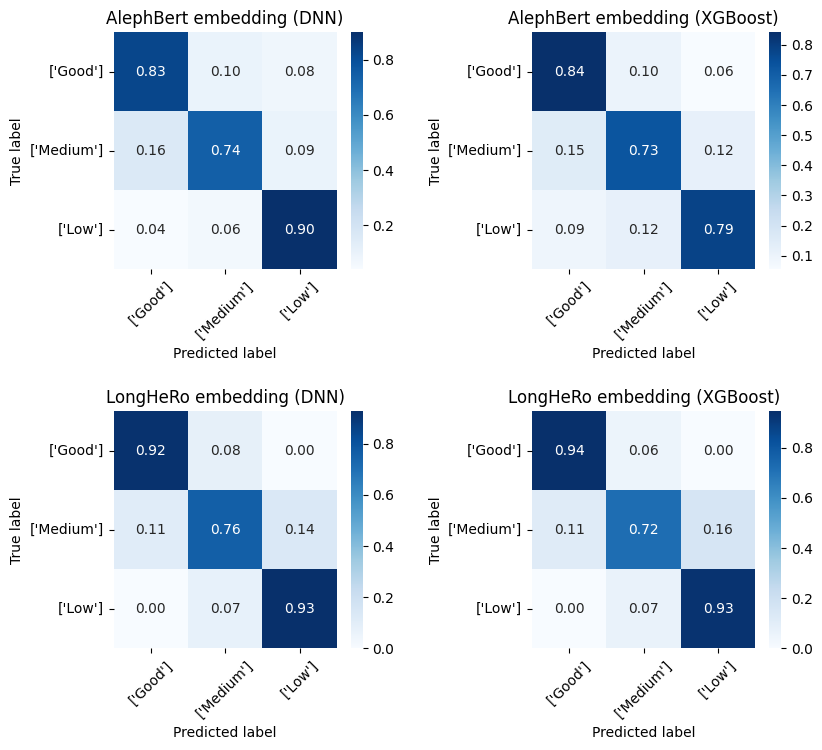

In [ ]:
y_pred = [y_pred_AlephBert_DNN, y_pred_AlephBert_xgb, y_pred_LongHeRo_DNN, y_pred_LongHeRo_xgb]
y_test = [y_test_AlephBert, y_test_AlephBert, y_test_LongHeRo, y_test_LongHeRo]

class_labels = ['[\'Good\']', '[\'Medium\']', '[\'Low\']']
cms = [confusion(y_test[i], y_pred[i], [2, 1, 0]) for i in range(4)]
titles = ['AlephBert embedding (DNN)', 'AlephBert embedding (XGBoost)', 'LongHeRo embedding (DNN)', 'LongHeRo embedding (XGBoost)']

plt.figure(figsize=(9, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.heatmap(cms[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(titles[i])

plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.show()


# Short context combined with long context

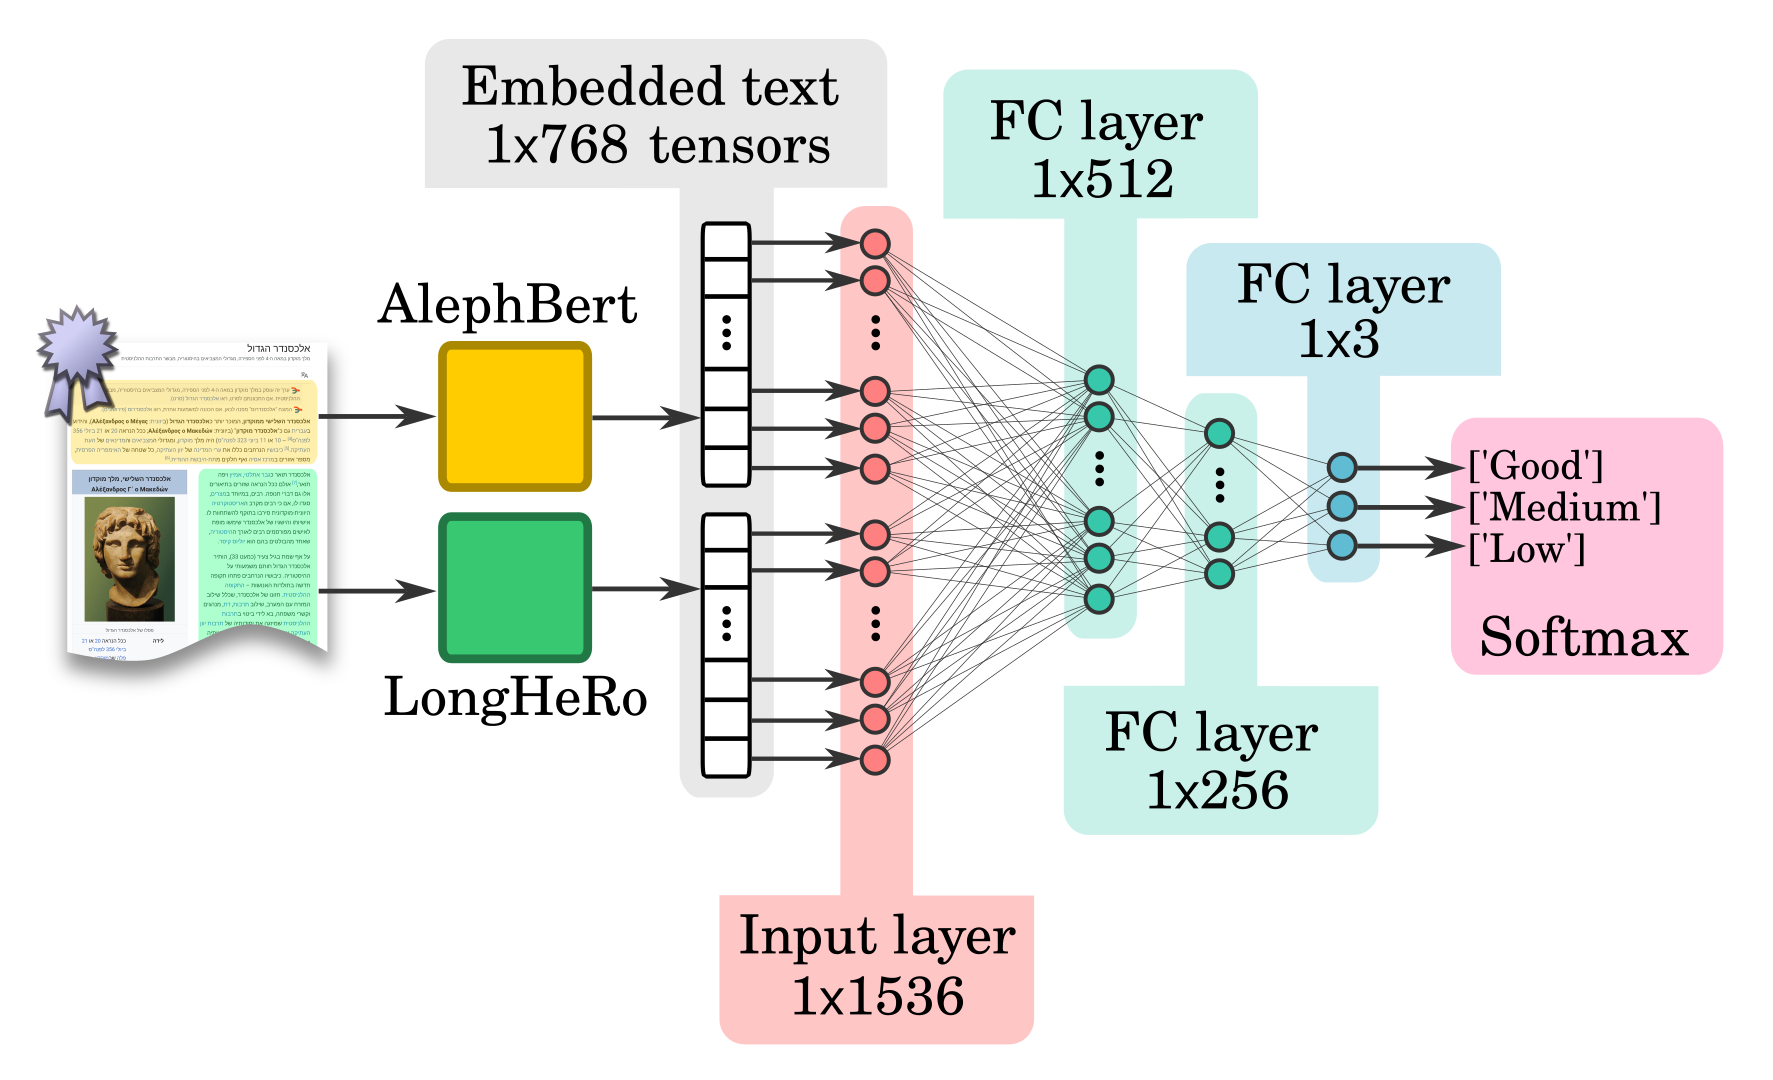

In [ ]:
df_AlephBert = pd.read_csv('wiki_data_with_AlephBERT_embedding.csv')
df_LongHeRo = pd.read_csv('wiki_data_with_LongHeRo_embedding.csv')

In [ ]:
def str_tensor(strr):
    return torch.tensor(eval(strr.split('tensor(')[1][:-1]))

df_AlephBert['AlephBERT_embedding'] = df_AlephBert['AlephBERT_embedding'].apply(lambda x: str_tensor(x))
df_LongHeRo['LongHeRo_embedding'] = df_LongHeRo['LongHeRo_embedding'].apply(lambda x: str_tensor(x))

In [ ]:
combined_embeddings = [torch.cat((aleph, longhero), dim=1) for aleph, longhero in zip(df_AlephBert['AlephBERT_embedding'], df_LongHeRo['LongHeRo_embedding'])]
combined_embeddings = torch.stack(combined_embeddings)
combined_embeddings = combined_embeddings.squeeze(1)

labels = torch.tensor(df_AlephBert['quality'].tolist(), dtype=torch.long)

In [ ]:
print(combined_embeddings[0].shape)

torch.Size([1536])


In [ ]:
class ComplexModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_dim = 1536
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 3

model = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

num_epochs = 200

## 5-fold cross-validation

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cms = []
reports = []

for i, (train_index, test_index) in enumerate(kf.split(combined_embeddings, labels)):
    print(f"Fold {i+1}")

    X_train, X_test = combined_embeddings[train_index], combined_embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, _labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, _labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if epoch % 40 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    print('\n')
    model.eval()
    y_pred = []

    with torch.no_grad():
        for inputs, _labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())

    y_test_list = y_test.tolist()

    cm = confusion(y_test_list, y_pred, [2, 1, 0])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cms.append(cm)

    report = classification_report(y_test_list, y_pred, target_names=['[\'Low\']', '[\'Medium\']', '[\'Good\']'])
    reports.append(report)

Fold 1
Epoch 0/200, Loss: 0.5380122448716845
Epoch 40/200, Loss: 0.01575065215251925
Epoch 80/200, Loss: 0.00010014120186139865
Epoch 120/200, Loss: 2.368981644654663e-05
Epoch 160/200, Loss: 6.41252563582384e-06


Fold 2
Epoch 0/200, Loss: 0.5063380684171405
Epoch 40/200, Loss: 0.0008248160276187784
Epoch 80/200, Loss: 3.856496506874204e-05
Epoch 120/200, Loss: 5.880577620790259e-06
Epoch 160/200, Loss: 1.2443602986118257e-06


Fold 3
Epoch 0/200, Loss: 0.48353916459849905
Epoch 40/200, Loss: 0.0005164424105714716
Epoch 80/200, Loss: 2.43569728257041e-05
Epoch 120/200, Loss: 3.4747496334221395e-06
Epoch 160/200, Loss: 7.270277934599636e-07


Fold 4
Epoch 0/200, Loss: 0.49657613251890453
Epoch 40/200, Loss: 0.0006623386798310094
Epoch 80/200, Loss: 5.5350370839083295e-05
Epoch 120/200, Loss: 9.686756340800326e-06
Epoch 160/200, Loss: 2.0984498394176806e-06


Fold 5
Epoch 0/200, Loss: 0.5216702725738287
Epoch 40/200, Loss: 0.0006482796444678181
Epoch 80/200, Loss: 4.091981495792295e-05


### Confusion matrices

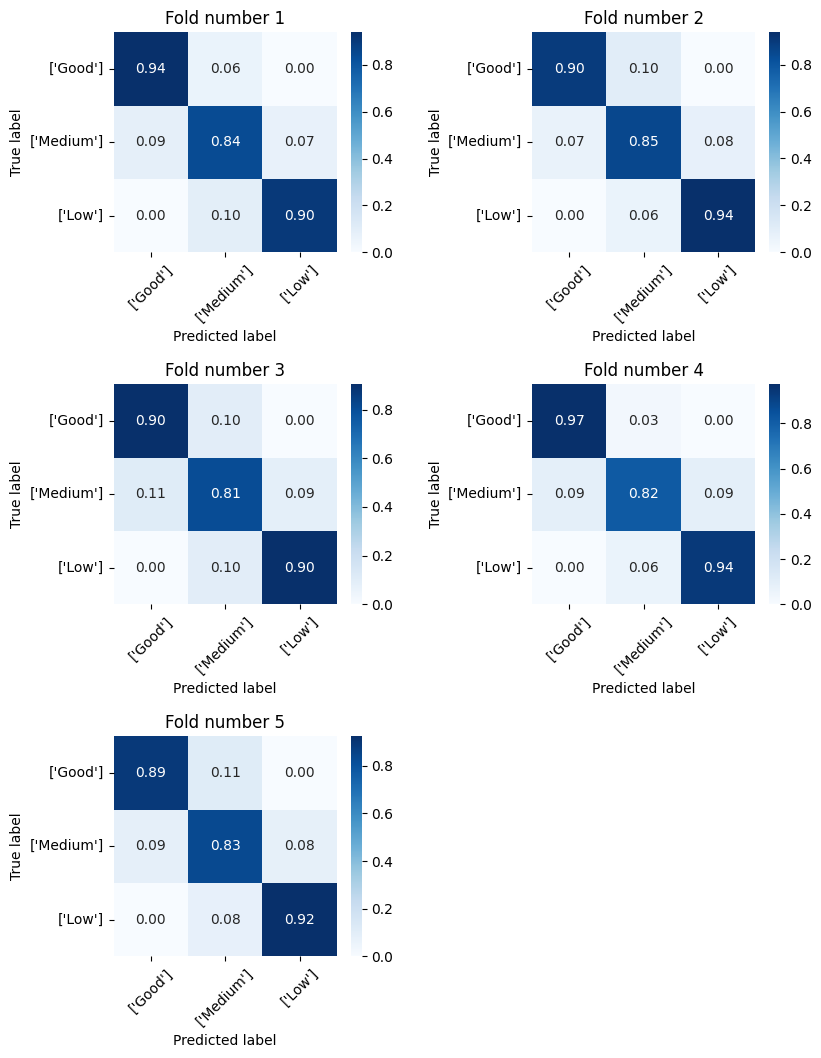

In [ ]:
class_labels = ['[\'Good\']', '[\'Medium\']', '[\'Low\']']

plt.figure(figsize=(9, 12))
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.heatmap(cms[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(f'Fold number {i+1}')

plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.show()

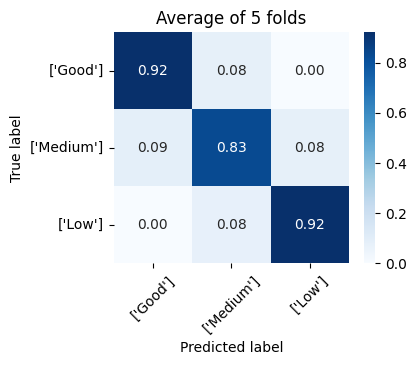

In [ ]:
avg_cm = np.mean(cms, axis=0)

plt.figure(figsize=(3.8, 3))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Average of 5 folds')
plt.show()

### precision & recall & f1-score

In [ ]:
for i, x in enumerate(reports):
    print(f'Fold number {i+1}:')
    print(x)
    print('\n')

Fold number 1:
              precision    recall  f1-score   support

     ['Low']       0.92      0.90      0.91       145
  ['Medium']       0.85      0.84      0.84       151
    ['Good']       0.91      0.94      0.93       146

    accuracy                           0.89       442
   macro avg       0.89      0.89      0.89       442
weighted avg       0.89      0.89      0.89       442



Fold number 2:
              precision    recall  f1-score   support

     ['Low']       0.92      0.94      0.93       145
  ['Medium']       0.84      0.85      0.85       151
    ['Good']       0.93      0.90      0.91       145

    accuracy                           0.90       441
   macro avg       0.90      0.90      0.90       441
weighted avg       0.90      0.90      0.90       441



Fold number 3:
              precision    recall  f1-score   support

     ['Low']       0.91      0.90      0.91       145
  ['Medium']       0.81      0.81      0.81       151
    ['Good']       0.89   